In [5]:
import sys

!{sys.executable} -m pip install convertdate
!{sys.executable} -m pip install fbprophet
!{sys.executable} -m pip install /ws/forks/neural_prophet['live']
!{sys.executable} -m pip install ray
!{sys.executable} -m pip install ../../../

Processing /ws/forks/neural_prophet
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 10.6 MB 3.9 MB/s eta 0:00:01
  Created wheel for neuralprophet: filename=neuralprophet-0.2.8-py3-none-any.whl size=58245 sha256=8ee88fc28400039455d8c078f4bf58853cd7648be252a8110b80c58d7ec08138
  Stored in directory: /tmp/pip-ephem-wheel-cache-tg2qao7a/wheels/4a/a7/79/b13901d81b7f94a0ed54b514d5c4fc1470bb8dfeb267205aa3
  Created wheel for bokeh: filename=bokeh-2.3.0-py3-none-any.whl size=11292265 sha256=daaa1249893745c92600efbf3f0822a85b0763931b0a1d5025dee060d44b6851
  Stored in directory: /root/.cache/pip/wheels/28/7b/fe/a0ab08baf17336c920feb7c1d8e80fdd1c473d273ed0772b77
Successfully built neuralprophet bokeh
Processing /ws/forks/timemachines
  Created wheel for timemachines: filename=timemachines-0.3.11-py3-none-any.whl size=375977 sha256=1afc8e08344386548c76f4c1a9fd0d54cbfd052f62d49b217

In [6]:
from fbprophet import Prophet
from neuralprophet import NeuralProphet

In [7]:
import pandas as pd

from timemachines.skatertools.data.real import hospital_with_exog, hospital
from timemachines.skaters.nproph.nprophskaterfactory import fbnprophet_skater_factory
from timemachines.skatertools.utilities.nonemath import nearlysame
from timemachines.skaters.nproph.nprophiskaterfactory import (
    nprophet_iskater_factory,
    nprophet_fit_and_predict_simple, 
    nprophet_fit_and_predict_with_time,
    nprophet_fit_and_predict_with_time_and_advance_time,
    nprophet_fit_and_predict_with_advance_vars, 
    nprophet_fit_and_predict_with_exog_and_advance_vars,
    nprophet_fit_and_predict_with_exog_and_advance_vars_no_t
)
from timemachines.skaters.nproph.nprophparams import (
    NPROPHET_MODEL, NPROPHET_META)

from timemachines.skatertools.utilities.epochtime import (
    infer_freq_from_epoch, is_valid_freq, epoch_to_naive_datetime, EPOCH)


def get_dataset(k, n):
    y, a = hospital_with_exog(k=k, n=n)
    y = y[:-k]
    t = [i * 15 * 50 for i in range(len(y) + k)]
    if t is None:
        if freq is None or not freq:
            freq = NPROPHET_META['freq']  # Just assume away ...
        else:
            assert is_valid_freq(freq), 'Freq ' + str(freq) + ' is not a valid frequency'
        dt = pd.date_range(start=EPOCH, periods=len(y), freq=freq)  # UTC
    else:
        freq = infer_freq_from_epoch(t)
        print('infering freq param as {}'.format(freq))
        dt = epoch_to_naive_datetime(t)

    if len(dt) == len(y) + k:
        ta = dt
        dt = dt[:len(y)]
    else:
        assert len(dt) == len(y), 'Time vector t should be len(y) or len(y)+k'
        ta = None

    # Massage data into Prophet friendly dataframe with columns y, y1, ..., yk, a0,...aj
    y_cols = ['y' + str(i) if i > 0 else 'y' for i in range(len(y[-1]))]
    if a:
        # TODO: Implement names as args
        a_cols = ['a' + str(i) for i in range(len(a[-1]))] 
        data = [
            list(yi) + list(ai) 
            for yi, ai
            in zip(y, a[:-k])
        ]
        df = pd.DataFrame(columns=y_cols+a_cols, data=data)
    else:
        data = [list(yi) for yi in y]
        df = pd.DataFrame(columns=y_cols, data=data)

    df['ds'] = dt
    return df,freq


In [13]:
!pwd

/ws/forks/timemachines/timemachines/skaters/nproph


In [8]:
from ray import tune

sweep_config = {
    'epochs': tune.grid_search([300]),
    'k': tune.grid_search([1,2,4,8,12,16]),
    'n': tune.grid_search([100, 500, 1000]),
    'n_lags': tune.grid_search([1, 2, 4, 8, 16, 32, 64]),
}

In [9]:
def training_function(model_params):
    # Hyperparameters
    df,freq = get_dataset(k=model_params['k'], n=model_params['n'])
    kwargs_used = dict([(k, v) for k, v in NPROPHET_MODEL.items()])
    for k in kwargs_used.keys():
        if k in model_params:
            kwargs_used[k] = model_params[k]
    
    m = NeuralProphet(**kwargs_used, )
    m = m.add_lagged_regressor(name='y1', normalize='auto')
    m = m.add_lagged_regressor(name='y2', normalize='auto')
    m = m.add_future_regressor(name='a0', normalize='auto')
    
    metrics = m.fit(
        df,
        freq=freq,
        validate_each_epoch=True,
        plot_live_loss=False,
        epochs=model_params['epochs']
    )
    
    # Feed the score back back to Tune.
    for step in metrics:
        for k,v in step.to_dict('records'):
            tune.report(k=v)

In [10]:
analysis = tune.run(
    training_function,
    config=sweep_config)

print(
    "Best config: ", analysis.get_best_config(
        metric="SmoothL1Loss", mode="min"
    )
)

# Get a dataframe for analyzing trial results.
analysis_df = analysis.results_df


(pid=1361) infering freq param as 750S
(pid=1363) infering freq param as 750S
(pid=1365) infering freq param as 750S
(pid=1364) infering freq param as 750S
(pid=1360) infering freq param as 750S
(pid=1366) infering freq param as 750S
(pid=1367) infering freq param as 750S
(pid=1362) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:10<00:00, 27.90it/s, SmoothL1Loss=0.000154, MAE=3.79, MSE=20.1, RegLoss=0, MAE_val=15, MSE_val=256, SmoothL1Loss_val=0.00197]
(pid=1364) Exception in thread Thread-2:
(pid=1364) Traceback (most recent call last):
(pid=1364)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=1364)     self.run()
(pid=1364)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=1364)     raise e
(pid=1364)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=1364)     self._entrypoint()
(pid=1364)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=1364)     self._status_reporter.get_checkpoint())
(pid=1364)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=1364)     output = fn()
(pid=1364)   File "<ipython-input-9-d2686e03cfb

Epoch[300/300]: 100%|██████████| 300/300 [00:10<00:00, 27.51it/s, SmoothL1Loss=0.000264, MAE=3.53, MSE=19.4, RegLoss=0, MAE_val=18.7, MSE_val=418, SmoothL1Loss_val=0.00568]
(pid=1360) Exception in thread Thread-2:
(pid=1360) Traceback (most recent call last):
(pid=1360)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=1360)     self.run()
(pid=1360)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=1360)     raise e
(pid=1360)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=1360)     self._entrypoint()
(pid=1360)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=1360)     self._status_reporter.get_checkpoint())
(pid=1360)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=1360)     output = fn()
(pid=1360)   File "<ipython-input-9-d2686e03c

(pid=1644) infering freq param as 750S
(pid=1645) infering freq param as 750S
(pid=1633) infering freq param as 750S
(pid=1648) infering freq param as 750S
(pid=1653) infering freq param as 750S
(pid=1653) 
(pid=1646) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [01:02<00:00,  4.83it/s, SmoothL1Loss=0.00014, MAE=3.48, MSE=18.9, RegLoss=0, MAE_val=7.95, MSE_val=84.7, SmoothL1Loss_val=0.000624]
(pid=1367) Exception in thread Thread-2:
(pid=1367) Traceback (most recent call last):
(pid=1367)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=1367)     self.run()
(pid=1367)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=1367)     raise e
(pid=1367)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=1367)     self._entrypoint()
(pid=1367)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=1367)     self._status_reporter.get_checkpoint())
(pid=1367)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=1367)     output = fn()
(pid=1367)   File "<ipython-input-9-d2686e03

Epoch[300/300]: 100%|██████████| 300/300 [01:02<00:00,  4.84it/s, SmoothL1Loss=0.000142, MAE=3.46, MSE=19.4, RegLoss=0, MAE_val=6.66, MSE_val=62.1, SmoothL1Loss_val=0.000453]
(pid=1362) Exception in thread Thread-2:
(pid=1362) Traceback (most recent call last):
(pid=1362)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=1362)     self.run()
(pid=1362)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=1362)     raise e
(pid=1362)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=1362)     self._entrypoint()
(pid=1362)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=1362)     self._status_reporter.get_checkpoint())
(pid=1362)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=1362)     output = fn()
(pid=1362)   File "<ipython-input-9-d2686e0

(pid=1990) infering freq param as 750S
(pid=1988) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:59<00:00,  5.03it/s, SmoothL1Loss=0.000221, MAE=4.26, MSE=27.3, RegLoss=0, MAE_val=8.6, MSE_val=103, SmoothL1Loss_val=0.000835]
(pid=1645) Exception in thread Thread-2:
(pid=1645) Traceback (most recent call last):
(pid=1645)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=1645)     self.run()
(pid=1645)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=1645)     raise e
(pid=1645)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=1645)     self._entrypoint()
(pid=1645)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=1645)     self._status_reporter.get_checkpoint())
(pid=1645)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=1645)     output = fn()
(pid=1645)   File "<ipython-input-9-d2686e03c

Epoch[300/300]: 100%|██████████| 300/300 [01:00<00:00,  4.97it/s, SmoothL1Loss=0.0002, MAE=3.95, MSE=24.7, RegLoss=0, MAE_val=6.14, MSE_val=56.5, SmoothL1Loss_val=0.000458]  
(pid=1648) Exception in thread Thread-2:
(pid=1648) Traceback (most recent call last):
(pid=1648)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=1648)     self.run()
(pid=1648)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=1648)     raise e
(pid=1648)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=1648)     self._entrypoint()
(pid=1648)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=1648)     self._status_reporter.get_checkpoint())
(pid=1648)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=1648)     output = fn()
(pid=1648)   File "<ipython-input-9-d2686e0

(pid=2123) infering freq param as 750S
(pid=2134) infering freq param as 750S


  4%|▍         | 8/197 [00:00<00:02, 78.47it/s]


(pid=2147) infering freq param as 750S


  0%|          | 0/196 [00:00<?, ?it/s]


(pid=2253) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:11<00:00, 26.32it/s, SmoothL1Loss=0.000246, MAE=2.97, MSE=13.7, RegLoss=0, MAE_val=6.66, MSE_val=59.8, SmoothL1Loss_val=0.00107]
(pid=2134) Exception in thread Thread-2:
(pid=2134) Traceback (most recent call last):
(pid=2134)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=2134)     self.run()
(pid=2134)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=2134)     raise e
(pid=2134)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=2134)     self._entrypoint()
(pid=2134)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=2134)     self._status_reporter.get_checkpoint())
(pid=2134)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=2134)     output = fn()
(pid=2134)   File "<ipython-input-9-d2686e03

Epoch[300/300]: 100%|██████████| 300/300 [00:11<00:00, 25.92it/s, SmoothL1Loss=0.00178, MAE=8.01, MSE=101, RegLoss=0, MAE_val=44.7, MSE_val=2.44e+3, SmoothL1Loss_val=0.043]
(pid=2253) Exception in thread Thread-2:
(pid=2253) Traceback (most recent call last):
(pid=2253)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=2253)     self.run()
(pid=2253)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=2253)     raise e
(pid=2253)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=2253)     self._entrypoint()
(pid=2253)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=2253)     self._status_reporter.get_checkpoint())
(pid=2253)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=2253)     output = fn()
(pid=2253)   File "<ipython-input-9-d2686e03c

(pid=2292) infering freq param as 750S


Epoch[8/300]:   2%|▏         | 6/300 [00:00<00:10, 27.38it/s, SmoothL1Loss=1.28, MAE=337, MSE=1.29e+5, RegLoss=0, MAE_val=577, MSE_val=3.41e+5, SmoothL1Loss_val=2.51]


(pid=2319) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:11<00:00, 26.53it/s, SmoothL1Loss=0.000244, MAE=3.61, MSE=17.9, RegLoss=0, MAE_val=22.2, MSE_val=647, SmoothL1Loss_val=0.00879]
(pid=2292) Exception in thread Thread-2:
(pid=2292) Traceback (most recent call last):
(pid=2292)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=2292)     self.run()
(pid=2292)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=2292)     raise e
(pid=2292)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=2292)     self._entrypoint()
(pid=2292)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=2292)     self._status_reporter.get_checkpoint())
(pid=2292)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=2292)     output = fn()
(pid=2292)   File "<ipython-input-9-d2686e03c

Epoch[300/300]: 100%|██████████| 300/300 [00:11<00:00, 26.46it/s, SmoothL1Loss=0.000152, MAE=2.98, MSE=13.1, RegLoss=0, MAE_val=13, MSE_val=183, SmoothL1Loss_val=0.00212]
(pid=2319) Exception in thread Thread-2:
(pid=2319) Traceback (most recent call last):
(pid=2319)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=2319)     self.run()
(pid=2319)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=2319)     raise e
(pid=2319)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=2319)     self._entrypoint()
(pid=2319)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=2319)     self._status_reporter.get_checkpoint())
(pid=2319)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=2319)     output = fn()
(pid=2319)   File "<ipython-input-9-d2686e03cfb

(pid=2352) infering freq param as 750S


Epoch[7/300]:   2%|▏         | 6/300 [00:00<00:10, 27.08it/s, SmoothL1Loss=1.07, MAE=411, MSE=2.03e+5, RegLoss=0, MAE_val=449, MSE_val=2.05e+5, SmoothL1Loss_val=1.19]


(pid=2378) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:11<00:00, 27.23it/s, SmoothL1Loss=0.000428, MAE=6.08, MSE=60.3, RegLoss=0, MAE_val=15, MSE_val=323, SmoothL1Loss_val=0.00229]
(pid=2352) Exception in thread Thread-2:
(pid=2352) Traceback (most recent call last):
(pid=2352)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=2352)     self.run()
(pid=2352)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=2352)     raise e
(pid=2352)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=2352)     self._entrypoint()
(pid=2352)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=2352)     self._status_reporter.get_checkpoint())
(pid=2352)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=2352)     output = fn()
(pid=2352)   File "<ipython-input-9-d2686e03cfb

Epoch[300/300]: 100%|██████████| 300/300 [00:11<00:00, 26.42it/s, SmoothL1Loss=0.000132, MAE=3.39, MSE=17.1, RegLoss=0, MAE_val=20.3, MSE_val=485, SmoothL1Loss_val=0.00374]
(pid=2378) Exception in thread Thread-2:
(pid=2378) Traceback (most recent call last):
(pid=2378)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=2378)     self.run()
(pid=2378)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=2378)     raise e
(pid=2378)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=2378)     self._entrypoint()
(pid=2378)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=2378)     self._status_reporter.get_checkpoint())
(pid=2378)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=2378)     output = fn()
(pid=2378)   File "<ipython-input-9-d2686e03c

Epoch[129/300]:  43%|████▎     | 129/300 [00:51<01:09,  2.44it/s, SmoothL1Loss=0.0211, MAE=37.6, MSE=2.27e+3, RegLoss=0, MAE_val=29.7, MSE_val=1.21e+3, SmoothL1Loss_val=0.0113]


(pid=2410) infering freq param as 750S


  0%|          | 0/230 [00:00<?, ?it/s]


(pid=2440) infering freq param as 750S
(pid=2437) infering freq param as 750S


Epoch[141/300]:  47%|████▋     | 141/300 [00:56<01:02,  2.55it/s, SmoothL1Loss=0.00179, MAE=10.6, MSE=193, RegLoss=0, MAE_val=14.3, MSE_val=306, SmoothL1Loss_val=0.00284]


(pid=2567) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [02:01<00:00,  2.46it/s, SmoothL1Loss=0.000211, MAE=3.83, MSE=22.7, RegLoss=0, MAE_val=5.28, MSE_val=46.3, SmoothL1Loss_val=0.00043]
(pid=1990) Exception in thread Thread-2:
(pid=1990) Traceback (most recent call last):
(pid=1990)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=1990)     self.run()
(pid=1990)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=1990)     raise e
(pid=1990)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=1990)     self._entrypoint()
(pid=1990)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=1990)     self._status_reporter.get_checkpoint())
(pid=1990)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=1990)     output = fn()
(pid=1990)   File "<ipython-input-9-d2686e03

Epoch[300/300]: 100%|██████████| 300/300 [02:02<00:00,  2.45it/s, SmoothL1Loss=0.000239, MAE=4.11, MSE=25.7, RegLoss=0, MAE_val=4.95, MSE_val=42.5, SmoothL1Loss_val=0.000395]
(pid=1988) Exception in thread Thread-2:
(pid=1988) Traceback (most recent call last):
(pid=1988)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=1988)     self.run()
(pid=1988)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=1988)     raise e
(pid=1988)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=1988)     self._entrypoint()
(pid=1988)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=1988)     self._status_reporter.get_checkpoint())
(pid=1988)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=1988)     output = fn()
(pid=1988)   File "<ipython-input-9-d2686e0

(pid=2605) infering freq param as 750S


Epoch[269/300]:  90%|████████▉ | 269/300 [00:53<00:06,  4.85it/s, SmoothL1Loss=0.000175, MAE=3.9, MSE=23.8, RegLoss=0, MAE_val=5.61, MSE_val=44.8, SmoothL1Loss_val=0.00033]  


(pid=2632) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:59<00:00,  5.02it/s, SmoothL1Loss=0.000132, MAE=3.34, MSE=18, RegLoss=0, MAE_val=4.97, MSE_val=37.5, SmoothL1Loss_val=0.000276]
(pid=2410) Exception in thread Thread-2:
(pid=2410) Traceback (most recent call last):
(pid=2410)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=2410)     self.run()
(pid=2410)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=2410)     raise e
(pid=2410)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=2410)     self._entrypoint()
(pid=2410)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=2410)     self._status_reporter.get_checkpoint())
(pid=2410)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=2410)     output = fn()
(pid=2410)   File "<ipython-input-9-d2686e03c

Epoch[300/300]: 100%|██████████| 300/300 [01:58<00:00,  2.52it/s, SmoothL1Loss=0.000152, MAE=3.22, MSE=16.4, RegLoss=0, MAE_val=4.04, MSE_val=29.7, SmoothL1Loss_val=0.000276]
(pid=2123) Exception in thread Thread-2:
(pid=2123) Traceback (most recent call last):
(pid=2123)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=2123)     self.run()
(pid=2123)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=2123)     raise e
(pid=2123)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=2123)     self._entrypoint()
(pid=2123)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=2123)     self._status_reporter.get_checkpoint())
(pid=2123)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=2123)     output = fn()
(pid=2123)   File "<ipython-input-9-d2686e0

(pid=2665) infering freq param as 750S


  0%|          | 0/245 [00:00<?, ?it/s]


(pid=2691) infering freq param as 750S


  2%|▏         | 6/245 [00:00<00:10, 23.38it/s]


(pid=2701) infering freq param as 750S


  0%|          | 0/245 [00:00<?, ?it/s]


(pid=2704) infering freq param as 750S
(pid=2703) infering freq param as 750S


 40%|████      | 99/245 [00:03<00:05, 27.83it/s]


(pid=2950) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [01:01<00:00,  4.85it/s, SmoothL1Loss=0.000178, MAE=3.77, MSE=22, RegLoss=0, MAE_val=5.67, MSE_val=49.1, SmoothL1Loss_val=0.000398]
(pid=2632) Exception in thread Thread-2:
(pid=2632) Traceback (most recent call last):
(pid=2632)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=2632)     self.run()
(pid=2632)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=2632)     raise e
(pid=2632)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=2632)     self._entrypoint()
(pid=2632)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=2632)     self._status_reporter.get_checkpoint())
(pid=2632)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=2632)     output = fn()
(pid=2632)   File "<ipython-input-9-d2686e03c

Epoch[300/300]: 100%|██████████| 300/300 [01:02<00:00,  4.84it/s, SmoothL1Loss=0.000154, MAE=3.49, MSE=19, RegLoss=0, MAE_val=3.97, MSE_val=23.1, SmoothL1Loss_val=0.000187]
(pid=2605) Exception in thread Thread-2:
(pid=2605) Traceback (most recent call last):
(pid=2605)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=2605)     self.run()
(pid=2605)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=2605)     raise e
(pid=2605)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=2605)     self._entrypoint()
(pid=2605)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=2605)     self._status_reporter.get_checkpoint())
(pid=2605)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=2605)     output = fn()
(pid=2605)   File "<ipython-input-9-d2686e03c

(pid=3028) infering freq param as 750S


 13%|█▎        | 26/196 [00:00<00:02, 75.21it/s]


(pid=3019) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:11<00:00, 27.08it/s, SmoothL1Loss=0.000188, MAE=2.53, MSE=10.5, RegLoss=0, MAE_val=16.5, MSE_val=354, SmoothL1Loss_val=0.00635]
(pid=3019) Exception in thread Thread-2:
(pid=3019) Traceback (most recent call last):
(pid=3019)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3019)     self.run()
(pid=3019)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3019)     raise e
(pid=3019)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3019)     self._entrypoint()
(pid=3019)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3019)     self._status_reporter.get_checkpoint())
(pid=3019)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3019)     output = fn()
(pid=3019)   File "<ipython-input-9-d2686e03c

  0%|          | 0/195 [00:00<?, ?it/s]


(pid=3157) infering freq param as 750S
(pid=3152) infering freq param as 750S


Epoch[292/300]:  97%|█████████▋| 291/300 [00:10<00:00, 26.88it/s, SmoothL1Loss=0.000209, MAE=3.26, MSE=15.4, RegLoss=0, MAE_val=15.5, MSE_val=285, SmoothL1Loss_val=0.00387]
(pid=3152) Exception in thread Thread-2:
(pid=3152) Traceback (most recent call last):
(pid=3152)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3152)     self.run()
(pid=3152)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3152)     raise e
(pid=3152)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3152)     self._entrypoint()
(pid=3152)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3152)     self._status_reporter.get_checkpoint())
(pid=3152)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3152)     output = fn()
(pid=3152)   File "<ipython-input-9-d2686e03c

Epoch[300/300]: 100%|██████████| 300/300 [00:11<00:00, 27.20it/s, SmoothL1Loss=0.000209, MAE=3.26, MSE=15.4, RegLoss=0, MAE_val=15.5, MSE_val=287, SmoothL1Loss_val=0.00389]
(pid=3157) Exception in thread Thread-2:
(pid=3157) Traceback (most recent call last):
(pid=3157)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3157)     self.run()
(pid=3157)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3157)     raise e
(pid=3157)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3157)     self._entrypoint()
(pid=3157)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3157)     self._status_reporter.get_checkpoint())
(pid=3157)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3157)     output = fn()
(pid=3157)   File "<ipython-input-9-d2686e03c

(pid=3285) infering freq param as 750S
(pid=3295) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:09<00:00, 32.71it/s, SmoothL1Loss=0.000829, MAE=8.71, MSE=108, RegLoss=0, MAE_val=16.8, MSE_val=410, SmoothL1Loss_val=0.00316]
(pid=3295) Exception in thread Thread-2:
(pid=3295) Traceback (most recent call last):
(pid=3295)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3295)     self.run()
(pid=3295)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3295)     raise e
(pid=3295)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3295)     self._entrypoint()
(pid=3295)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3295)     self._status_reporter.get_checkpoint())
(pid=3295)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3295)     output = fn()
(pid=3295)   File "<ipython-input-9-d2686e03cf

Epoch[300/300]: 100%|██████████| 300/300 [00:11<00:00, 26.90it/s, SmoothL1Loss=0.000279, MAE=4.81, MSE=39.3, RegLoss=0, MAE_val=14.1, MSE_val=249, SmoothL1Loss_val=0.00176]
(pid=3285) Exception in thread Thread-2:
(pid=3285) Traceback (most recent call last):
(pid=3285)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3285)     self.run()
(pid=3285)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3285)     raise e
(pid=3285)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3285)     self._entrypoint()
(pid=3285)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3285)     self._status_reporter.get_checkpoint())
(pid=3285)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3285)     output = fn()
(pid=3285)   File "<ipython-input-9-d2686e03c

(pid=3421) infering freq param as 750S


  0%|          | 0/230 [00:00<?, ?it/s]


(pid=3448) infering freq param as 750S


Epoch[43/300]:  14%|█▍        | 43/300 [00:08<00:50,  5.12it/s, SmoothL1Loss=0.000511, MAE=6.82, MSE=69.3, RegLoss=0, MAE_val=6.97, MSE_val=88.1, SmoothL1Loss_val=0.000649]
(pid=2691) Exception in thread Thread-2:
(pid=2691) Traceback (most recent call last):
(pid=2691)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=2691)     self.run()
(pid=2691)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=2691)     raise e
(pid=2691)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=2691)     self._entrypoint()
(pid=2691)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=2691)     self._status_reporter.get_checkpoint())
(pid=2691)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=2691)     output = fn()
(pid=2691)   File "<ipython-input-9-d2686e03c

Epoch[300/300]: 100%|██████████| 300/300 [02:02<00:00,  2.45it/s, SmoothL1Loss=0.000173, MAE=3.48, MSE=19.2, RegLoss=0, MAE_val=3.99, MSE_val=26.8, SmoothL1Loss_val=0.000241]
(pid=2665) Exception in thread Thread-2:
(pid=2665) Traceback (most recent call last):
(pid=2665)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=2665)     self.run()
(pid=2665)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=2665)     raise e
(pid=2665)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=2665)     self._entrypoint()
(pid=2665)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=2665)     self._status_reporter.get_checkpoint())
(pid=2665)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=2665)     output = fn()
(pid=2665)   File "<ipython-input-9-d2686e0

(pid=3483) infering freq param as 750S


 13%|█▎        | 30/230 [00:00<00:05, 39.53it/s]


(pid=3509) infering freq param as 750S


Epoch[74/300]:  25%|██▍       | 74/300 [00:15<00:45,  4.97it/s, SmoothL1Loss=0.00189, MAE=12.9, MSE=258, RegLoss=0, MAE_val=15, MSE_val=346, SmoothL1Loss_val=0.00253]


(pid=3536) infering freq param as 750S


  2%|▏         | 4/229 [00:00<00:05, 38.70it/s]


(pid=3563) infering freq param as 750S


 59%|█████▊    | 135/230 [00:03<00:02, 45.43it/s]


(pid=3589) infering freq param as 750S


  0%|          | 0/245 [00:00<?, ?it/s]


(pid=3600) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [01:02<00:00,  4.82it/s, SmoothL1Loss=0.000133, MAE=3.34, MSE=18, RegLoss=0, MAE_val=4.49, MSE_val=30.5, SmoothL1Loss_val=0.000225]
(pid=3421) Exception in thread Thread-2:
(pid=3421) Traceback (most recent call last):
(pid=3421)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3421)     self.run()
(pid=3421)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3421)     raise e
(pid=3421)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3421)     self._entrypoint()
(pid=3421)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3421)     self._status_reporter.get_checkpoint())
(pid=3421)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3421)     output = fn()
(pid=3421)   File "<ipython-input-9-d2686e03c

Epoch[300/300]: 100%|██████████| 300/300 [01:01<00:00,  4.89it/s, SmoothL1Loss=0.000154, MAE=3.67, MSE=21, RegLoss=0, MAE_val=6.36, MSE_val=59.4, SmoothL1Loss_val=0.000433]
(pid=3448) Exception in thread Thread-2:
(pid=3448) Traceback (most recent call last):
(pid=3448)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3448)     self.run()
(pid=3448)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3448)     raise e
(pid=3448)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3448)     self._entrypoint()
(pid=3448)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3448)     self._status_reporter.get_checkpoint())
(pid=3448)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3448)     output = fn()
(pid=3448)   File "<ipython-input-9-d2686e03c

(pid=3736) infering freq param as 750S


  0%|          | 0/245 [00:00<?, ?it/s]


(pid=3763) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:59<00:00,  5.02it/s, SmoothL1Loss=0.000189, MAE=3.93, MSE=23.4, RegLoss=0, MAE_val=7.85, MSE_val=84.7, SmoothL1Loss_val=0.000686]
(pid=3509) Exception in thread Thread-2:
(pid=3509) Traceback (most recent call last):
(pid=3509)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3509)     self.run()
(pid=3509)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3509)     raise e
(pid=3509)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3509)     self._entrypoint()
(pid=3509)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3509)     self._status_reporter.get_checkpoint())
(pid=3509)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3509)     output = fn()
(pid=3509)   File "<ipython-input-9-d2686e0

Epoch[300/300]: 100%|██████████| 300/300 [01:00<00:00,  4.93it/s, SmoothL1Loss=0.000155, MAE=3.68, MSE=21.2, RegLoss=0, MAE_val=4.47, MSE_val=28.4, SmoothL1Loss_val=0.000207]
(pid=3483) Exception in thread Thread-2:
(pid=3483) Traceback (most recent call last):
(pid=3483)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3483)     self.run()
(pid=3483)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3483)     raise e
(pid=3483)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3483)     self._entrypoint()
(pid=3483)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3483)     self._status_reporter.get_checkpoint())
(pid=3483)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3483)     output = fn()
(pid=3483)   File "<ipython-input-9-d2686e0

(pid=3810) infering freq param as 750S
(pid=3796) infering freq param as 750S


  5%|▍         | 9/195 [00:00<00:02, 83.60it/s]


(pid=3807) infering freq param as 750S


 15%|█▍        | 29/195 [00:00<00:01, 90.99it/s]


(pid=3861) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:11<00:00, 26.99it/s, SmoothL1Loss=0.000259, MAE=2.94, MSE=14.3, RegLoss=0, MAE_val=9.86, MSE_val=128, SmoothL1Loss_val=0.00233]
(pid=3807) Exception in thread Thread-2:
(pid=3807) Traceback (most recent call last):
(pid=3807)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3807)     self.run()
(pid=3807)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3807)     raise e
(pid=3807)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3807)     self._entrypoint()
(pid=3807)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3807)     self._status_reporter.get_checkpoint())
(pid=3807)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3807)     output = fn()
(pid=3807)   File "<ipython-input-9-d2686e03c

Epoch[300/300]: 100%|██████████| 300/300 [00:11<00:00, 25.89it/s, SmoothL1Loss=0.000522, MAE=4.62, MSE=29.6, RegLoss=0, MAE_val=26.4, MSE_val=964, SmoothL1Loss_val=0.017]
(pid=3861) Exception in thread Thread-2:
(pid=3861) Traceback (most recent call last):
(pid=3861)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3861)     self.run()
(pid=3861)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3861)     raise e
(pid=3861)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3861)     self._entrypoint()
(pid=3861)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3861)     self._status_reporter.get_checkpoint())
(pid=3861)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3861)     output = fn()
(pid=3861)   File "<ipython-input-9-d2686e03cfb

(pid=4042) infering freq param as 750S


  0%|          | 0/194 [00:00<?, ?it/s]


(pid=4068) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:10<00:00, 27.30it/s, SmoothL1Loss=0.000254, MAE=3.69, MSE=19.6, RegLoss=0, MAE_val=4.85, MSE_val=35, SmoothL1Loss_val=0.000453]
(pid=4042) Exception in thread Thread-2:
(pid=4042) Traceback (most recent call last):
(pid=4042)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4042)     self.run()
(pid=4042)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4042)     raise e
(pid=4042)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4042)     self._entrypoint()
(pid=4042)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4042)     self._status_reporter.get_checkpoint())
(pid=4042)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4042)     output = fn()
(pid=4042)   File "<ipython-input-9-d2686e03c

Epoch[300/300]: 100%|██████████| 300/300 [00:11<00:00, 26.63it/s, SmoothL1Loss=0.000147, MAE=2.97, MSE=12.8, RegLoss=0, MAE_val=5.78, MSE_val=49.2, SmoothL1Loss_val=0.000568]
(pid=4068) Exception in thread Thread-2:
(pid=4068) Traceback (most recent call last):
(pid=4068)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4068)     self.run()
(pid=4068)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4068)     raise e
(pid=4068)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4068)     self._entrypoint()
(pid=4068)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4068)     self._status_reporter.get_checkpoint())
(pid=4068)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4068)     output = fn()
(pid=4068)   File "<ipython-input-9-d2686e0

(pid=4102) infering freq param as 750S


  0%|          | 0/192 [00:00<?, ?it/s]


(pid=4127) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:09<00:00, 33.08it/s, SmoothL1Loss=0.000217, MAE=4.53, MSE=30.7, RegLoss=0, MAE_val=34.3, MSE_val=1.8e+3, SmoothL1Loss_val=0.0128]
(pid=4127) Exception in thread Thread-2:
(pid=4127) Traceback (most recent call last):
(pid=4127)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4127)     self.run()
(pid=4127)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4127)     raise e
(pid=4127)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4127)     self._entrypoint()
(pid=4127)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4127)     self._status_reporter.get_checkpoint())
(pid=4127)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4127)     output = fn()
(pid=4127)   File "<ipython-input-9-d2686e0

  0%|          | 0/230 [00:00<?, ?it/s]


(pid=4168) infering freq param as 750S
(pid=4166) infering freq param as 750S


Epoch[1/300]:   0%|          | 1/300 [00:00<00:55,  5.39it/s, SmoothL1Loss=0.327, MAE=166, MSE=4.2e+4, RegLoss=0, MAE_val=168, MSE_val=4.24e+4, SmoothL1Loss_val=0.334]
(pid=3600) Exception in thread Thread-2:
(pid=3600) Traceback (most recent call last):
(pid=3600)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3600)     self.run()
(pid=3600)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3600)     raise e
(pid=3600)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3600)     self._entrypoint()
(pid=3600)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3600)     self._status_reporter.get_checkpoint())
(pid=3600)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3600)     output = fn()
(pid=3600)   File "<ipython-input-9-d2686e03cfb0>"

Epoch[300/300]: 100%|██████████| 300/300 [02:04<00:00,  2.41it/s, SmoothL1Loss=0.000168, MAE=3.42, MSE=18.7, RegLoss=0, MAE_val=3.69, MSE_val=22.8, SmoothL1Loss_val=0.000205]
(pid=3589) Exception in thread Thread-2:
(pid=3589) Traceback (most recent call last):
(pid=3589)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3589)     self.run()
(pid=3589)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3589)     raise e
(pid=3589)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3589)     self._entrypoint()
(pid=3589)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3589)     self._status_reporter.get_checkpoint())
(pid=3589)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3589)     output = fn()
(pid=3589)   File "<ipython-input-9-d2686e0

(pid=4297) infering freq param as 750S


  0%|          | 0/229 [00:00<?, ?it/s]


(pid=4322) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [02:02<00:00,  2.45it/s, SmoothL1Loss=0.0002, MAE=3.68, MSE=21.5, RegLoss=0, MAE_val=3.99, MSE_val=29.7, SmoothL1Loss_val=0.000276]
(pid=3736) Exception in thread Thread-2:
(pid=3736) Traceback (most recent call last):
(pid=3736)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3736)     self.run()
(pid=3736)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3736)     raise e
(pid=3736)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3736)     self._entrypoint()
(pid=3736)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3736)     self._status_reporter.get_checkpoint())
(pid=3736)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3736)     output = fn()
(pid=3736)   File "<ipython-input-9-d2686e03c

Epoch[300/300]: 100%|██████████| 300/300 [02:03<00:00,  2.43it/s, SmoothL1Loss=0.00019, MAE=3.63, MSE=20.5, RegLoss=0, MAE_val=4.6, MSE_val=38.2, SmoothL1Loss_val=0.000355] 
(pid=3763) Exception in thread Thread-2:
(pid=3763) Traceback (most recent call last):
(pid=3763)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3763)     self.run()
(pid=3763)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3763)     raise e
(pid=3763)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3763)     self._entrypoint()
(pid=3763)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3763)     self._status_reporter.get_checkpoint())
(pid=3763)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3763)     output = fn()
(pid=3763)   File "<ipython-input-9-d2686e03

(pid=4358) infering freq param as 750S


 33%|███▎      | 76/229 [00:01<00:03, 45.85it/s]


(pid=4384) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [01:00<00:00,  4.92it/s, SmoothL1Loss=0.000157, MAE=3.4, MSE=18.4, RegLoss=0, MAE_val=4.09, MSE_val=25.7, SmoothL1Loss_val=0.000219]
(pid=4166) Exception in thread Thread-2:
(pid=4166) Traceback (most recent call last):
(pid=4166)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4166)     self.run()
(pid=4166)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4166)     raise e
(pid=4166)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4166)     self._entrypoint()
(pid=4166)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4166)     self._status_reporter.get_checkpoint())
(pid=4166)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4166)     output = fn()
(pid=4166)   File "<ipython-input-9-d2686e03

Epoch[300/300]: 100%|██████████| 300/300 [01:57<00:00,  2.55it/s, SmoothL1Loss=0.000187, MAE=3.54, MSE=20.2, RegLoss=0, MAE_val=3.91, MSE_val=26.1, SmoothL1Loss_val=0.000242]
(pid=3810) Exception in thread Thread-2:
(pid=3810) Traceback (most recent call last):
(pid=3810)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=3810)     self.run()
(pid=3810)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=3810)     raise e
(pid=3810)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=3810)     self._entrypoint()
(pid=3810)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=3810)     self._status_reporter.get_checkpoint())
(pid=3810)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=3810)     output = fn()
(pid=3810)   File "<ipython-input-9-d2686e0

(pid=4416) infering freq param as 750S


  0%|          | 0/245 [00:00<?, ?it/s]


(pid=4443) infering freq param as 750S


  2%|▏         | 6/245 [00:00<00:09, 25.43it/s]


(pid=4457) infering freq param as 750S


Epoch[290/300]:  97%|█████████▋| 290/300 [00:59<00:01,  5.01it/s, SmoothL1Loss=0.000169, MAE=3.7, MSE=20.8, RegLoss=0, MAE_val=6.24, MSE_val=58.6, SmoothL1Loss_val=0.000474] 


(pid=4492) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [01:01<00:00,  4.86it/s, SmoothL1Loss=0.000164, MAE=3.66, MSE=20.3, RegLoss=0, MAE_val=6.22, MSE_val=58.3, SmoothL1Loss_val=0.000472]
(pid=4322) Exception in thread Thread-2:
(pid=4322) Traceback (most recent call last):
(pid=4322)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4322)     self.run()
(pid=4322)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4322)     raise e
(pid=4322)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4322)     self._entrypoint()
(pid=4322)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4322)     self._status_reporter.get_checkpoint())
(pid=4322)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4322)     output = fn()
(pid=4322)   File "<ipython-input-9-d2686e0

Epoch[300/300]: 100%|██████████| 300/300 [01:02<00:00,  4.77it/s, SmoothL1Loss=0.000163, MAE=3.75, MSE=22.4, RegLoss=0, MAE_val=4.81, MSE_val=38.8, SmoothL1Loss_val=0.000283]
(pid=4297) Exception in thread Thread-2:
(pid=4297) Traceback (most recent call last):
(pid=4297)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4297)     self.run()
(pid=4297)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4297)     raise e
(pid=4297)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4297)     self._entrypoint()
(pid=4297)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4297)     self._status_reporter.get_checkpoint())
(pid=4297)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4297)     output = fn()
(pid=4297)   File "<ipython-input-9-d2686e0

(pid=4586) infering freq param as 750S


  8%|▊         | 20/244 [00:00<00:08, 27.52it/s]


(pid=4613) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:58<00:00,  5.16it/s, SmoothL1Loss=0.000173, MAE=3.72, MSE=21.4, RegLoss=0, MAE_val=6.57, MSE_val=59.6, SmoothL1Loss_val=0.000483]
(pid=4384) Exception in thread Thread-2:
(pid=4384) Traceback (most recent call last):
(pid=4384)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4384)     self.run()
(pid=4384)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4384)     raise e
(pid=4384)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4384)     self._entrypoint()
(pid=4384)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4384)     self._status_reporter.get_checkpoint())
(pid=4384)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4384)     output = fn()
(pid=4384)   File "<ipython-input-9-d2686e0

Epoch[300/300]: 100%|██████████| 300/300 [01:01<00:00,  4.91it/s, SmoothL1Loss=0.000161, MAE=3.56, MSE=19.9, RegLoss=0, MAE_val=4.62, MSE_val=31.1, SmoothL1Loss_val=0.000252]
(pid=4358) Exception in thread Thread-2:
(pid=4358) Traceback (most recent call last):
(pid=4358)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4358)     self.run()
(pid=4358)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4358)     raise e
(pid=4358)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4358)     self._entrypoint()
(pid=4358)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4358)     self._status_reporter.get_checkpoint())
(pid=4358)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4358)     output = fn()
(pid=4358)   File "<ipython-input-9-d2686e0

(pid=4646) infering freq param as 750S


  3%|▎         | 6/194 [00:00<00:03, 58.62it/s]


(pid=4673) infering freq param as 750S


Epoch[283/300]:  94%|█████████▍| 282/300 [00:10<00:00, 26.86it/s, SmoothL1Loss=0.000952, MAE=5.87, MSE=53.1, RegLoss=0, MAE_val=17.5, MSE_val=480, SmoothL1Loss_val=0.00861]
(pid=4646) Exception in thread Thread-2:
(pid=4646) Traceback (most recent call last):
(pid=4646)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4646)     self.run()
(pid=4646)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4646)     raise e
(pid=4646)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4646)     self._entrypoint()
(pid=4646)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4646)     self._status_reporter.get_checkpoint())
(pid=4646)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4646)     output = fn()
(pid=4646)   File "<ipython-input-9-d2686e03c

Epoch[300/300]: 100%|██████████| 300/300 [00:11<00:00, 26.95it/s, SmoothL1Loss=0.000953, MAE=5.73, MSE=53.2, RegLoss=0, MAE_val=17.6, MSE_val=491, SmoothL1Loss_val=0.0088]
(pid=4673) Exception in thread Thread-2:
(pid=4673) Traceback (most recent call last):
(pid=4673)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4673)     self.run()
(pid=4673)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4673)     raise e
(pid=4673)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4673)     self._entrypoint()
(pid=4673)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4673)     self._status_reporter.get_checkpoint())
(pid=4673)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4673)     output = fn()
(pid=4673)   File "<ipython-input-9-d2686e03cf

(pid=4707) infering freq param as 750S
(pid=4717) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:09<00:00, 33.33it/s, SmoothL1Loss=0.000141, MAE=3.01, MSE=12.2, RegLoss=0, MAE_val=25.7, MSE_val=851, SmoothL1Loss_val=0.00984]
(pid=4717) Exception in thread Thread-2:
(pid=4717) Traceback (most recent call last):
(pid=4717)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4717)     self.run()
(pid=4717)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4717)     raise e
(pid=4717)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4717)     self._entrypoint()
(pid=4717)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4717)     self._status_reporter.get_checkpoint())
(pid=4717)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4717)     output = fn()
(pid=4717)   File "<ipython-input-9-d2686e03c

Epoch[300/300]: 100%|██████████| 300/300 [00:09<00:00, 32.03it/s, SmoothL1Loss=0.000147, MAE=2.81, MSE=11.3, RegLoss=0, MAE_val=10.2, MSE_val=212, SmoothL1Loss_val=0.00274]
(pid=4707) Exception in thread Thread-2:
(pid=4707) Traceback (most recent call last):
(pid=4707)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4707)     self.run()
(pid=4707)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4707)     raise e
(pid=4707)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4707)     self._entrypoint()
(pid=4707)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4707)     self._status_reporter.get_checkpoint())
(pid=4707)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4707)     output = fn()
(pid=4707)   File "<ipython-input-9-d2686e03c

(pid=4842) infering freq param as 750S
(pid=4847) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:08<00:00, 33.91it/s, SmoothL1Loss=0.000198, MAE=3.75, MSE=27.9, RegLoss=0, MAE_val=12.2, MSE_val=216, SmoothL1Loss_val=0.00153]
(pid=4847) Exception in thread Thread-2:
(pid=4847) Traceback (most recent call last):
(pid=4847)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4847)     self.run()
(pid=4847)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4847)     raise e
(pid=4847)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4847)     self._entrypoint()
(pid=4847)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4847)     self._status_reporter.get_checkpoint())
(pid=4847)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4847)     output = fn()
(pid=4847)   File "<ipython-input-9-d2686e03c

Epoch[300/300]: 100%|██████████| 300/300 [00:09<00:00, 33.29it/s, SmoothL1Loss=0.000103, MAE=2.88, MSE=14.5, RegLoss=0, MAE_val=6.98, MSE_val=68.5, SmoothL1Loss_val=0.000485]
(pid=4842) Exception in thread Thread-2:
(pid=4842) Traceback (most recent call last):
(pid=4842)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4842)     self.run()
(pid=4842)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4842)     raise e
(pid=4842)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4842)     self._entrypoint()
(pid=4842)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4842)     self._status_reporter.get_checkpoint())
(pid=4842)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4842)     output = fn()
(pid=4842)   File "<ipython-input-9-d2686e0

(pid=4981) infering freq param as 750S
(pid=4976) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [02:01<00:00,  2.48it/s, SmoothL1Loss=0.000175, MAE=3.56, MSE=19.5, RegLoss=0, MAE_val=3.75, MSE_val=22.7, SmoothL1Loss_val=0.000204]
(pid=4416) Exception in thread Thread-2:
(pid=4416) Traceback (most recent call last):
(pid=4416)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4416)     self.run()
(pid=4416)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4416)     raise e
(pid=4416)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4416)     self._entrypoint()
(pid=4416)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4416)     self._status_reporter.get_checkpoint())
(pid=4416)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4416)     output = fn()
(pid=4416)   File "<ipython-input-9-d2686e0

Epoch[300/300]: 100%|██████████| 300/300 [02:01<00:00,  2.47it/s, SmoothL1Loss=0.00016, MAE=3.35, MSE=17.8, RegLoss=0, MAE_val=3.75, MSE_val=24.7, SmoothL1Loss_val=0.000222]
(pid=4443) Exception in thread Thread-2:
(pid=4443) Traceback (most recent call last):
(pid=4443)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4443)     self.run()
(pid=4443)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4443)     raise e
(pid=4443)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4443)     self._entrypoint()
(pid=4443)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4443)     self._status_reporter.get_checkpoint())
(pid=4443)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4443)     output = fn()
(pid=4443)   File "<ipython-input-9-d2686e03

Epoch[80/300]:  27%|██▋       | 80/300 [00:17<00:47,  4.66it/s, SmoothL1Loss=0.364, MAE=170, MSE=5.31e+4, RegLoss=0, MAE_val=152, MSE_val=4.07e+4, SmoothL1Loss_val=0.303] 


(pid=5110) infering freq param as 750S


 21%|██▏       | 49/229 [00:01<00:03, 45.80it/s]


(pid=5137) infering freq param as 750S


  0%|          | 0/229 [00:00<?, ?it/s]


(pid=5164) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [01:59<00:00,  2.51it/s, SmoothL1Loss=0.00015, MAE=3.16, MSE=16.2, RegLoss=0, MAE_val=4.01, MSE_val=26.3, SmoothL1Loss_val=0.000244]
(pid=4586) Exception in thread Thread-2:
(pid=4586) Traceback (most recent call last):
(pid=4586)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4586)     self.run()
(pid=4586)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4586)     raise e
(pid=4586)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4586)     self._entrypoint()
(pid=4586)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4586)     self._status_reporter.get_checkpoint())
(pid=4586)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4586)     output = fn()
(pid=4586)   File "<ipython-input-9-d2686e03

Epoch[300/300]: 100%|██████████| 300/300 [01:59<00:00,  2.50it/s, SmoothL1Loss=0.000183, MAE=3.53, MSE=19.7, RegLoss=0, MAE_val=4.27, MSE_val=32, SmoothL1Loss_val=0.000298]
(pid=4613) Exception in thread Thread-2:
(pid=4613) Traceback (most recent call last):
(pid=4613)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4613)     self.run()
(pid=4613)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4613)     raise e
(pid=4613)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4613)     self._entrypoint()
(pid=4613)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4613)     self._status_reporter.get_checkpoint())
(pid=4613)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4613)     output = fn()
(pid=4613)   File "<ipython-input-9-d2686e03c

(pid=5191) infering freq param as 750S


Epoch[17/300]:   6%|▌         | 17/300 [00:03<00:53,  5.25it/s, SmoothL1Loss=0.032, MAE=46.9, MSE=3.97e+3, RegLoss=0, MAE_val=58.3, MSE_val=5.62e+3, SmoothL1Loss_val=0.0455]


(pid=5228) infering freq param as 750S


  0%|          | 0/245 [00:00<?, ?it/s]


(pid=5254) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [01:01<00:00,  4.85it/s, SmoothL1Loss=0.000146, MAE=3.31, MSE=17.2, RegLoss=0, MAE_val=5.69, MSE_val=51.2, SmoothL1Loss_val=0.000435]
(pid=4976) Exception in thread Thread-2:
(pid=4976) Traceback (most recent call last):
(pid=4976)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4976)     self.run()
(pid=4976)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4976)     raise e
(pid=4976)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4976)     self._entrypoint()
(pid=4976)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4976)     self._status_reporter.get_checkpoint())
(pid=4976)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4976)     output = fn()
(pid=4976)   File "<ipython-input-9-d2686e0

Epoch[209/300]:  70%|██████▉   | 209/300 [00:41<00:18,  4.99it/s, SmoothL1Loss=0.000493, MAE=6.57, MSE=67.6, RegLoss=0, MAE_val=5.61, MSE_val=47.1, SmoothL1Loss_val=0.000344]
(pid=4981) Exception in thread Thread-2:
(pid=4981) Traceback (most recent call last):
(pid=4981)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=4981)     self.run()
(pid=4981)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=4981)     raise e
(pid=4981)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=4981)     self._entrypoint()
(pid=4981)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=4981)     self._status_reporter.get_checkpoint())
(pid=4981)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=4981)     output = fn()
(pid=4981)   File "<ipython-input-9-d2686e0

(pid=5316) infering freq param as 750S


Epoch[217/300]:  72%|███████▏  | 217/300 [00:42<00:15,  5.24it/s, SmoothL1Loss=0.00192, MAE=11.7, MSE=237, RegLoss=0, MAE_val=9.51, MSE_val=141, SmoothL1Loss_val=0.00114]


(pid=5332) infering freq param as 750S


Epoch[9/300]:   3%|▎         | 9/300 [00:03<01:54,  2.53it/s, SmoothL1Loss=0.0252, MAE=42.6, MSE=2.73e+3, RegLoss=0, MAE_val=56.8, MSE_val=5.51e+3, SmoothL1Loss_val=0.0506]
(pid=5137) Exception in thread Thread-2:
(pid=5137) Traceback (most recent call last):
(pid=5137)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5137)     self.run()
(pid=5137)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5137)     raise e
(pid=5137)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5137)     self._entrypoint()
(pid=5137)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5137)     self._status_reporter.get_checkpoint())
(pid=5137)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5137)     output = fn()
(pid=5137)   File "<ipython-input-9-d2686e03c

Epoch[300/300]: 100%|██████████| 300/300 [00:59<00:00,  5.05it/s, SmoothL1Loss=0.00015, MAE=3.66, MSE=20.5, RegLoss=0, MAE_val=5.07, MSE_val=39.6, SmoothL1Loss_val=0.000289]
(pid=5110) Exception in thread Thread-2:
(pid=5110) Traceback (most recent call last):
(pid=5110)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5110)     self.run()
(pid=5110)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5110)     raise e
(pid=5110)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5110)     self._entrypoint()
(pid=5110)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5110)     self._status_reporter.get_checkpoint())
(pid=5110)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5110)     output = fn()
(pid=5110)   File "<ipython-input-9-d2686e03

Epoch[25/300]:   8%|▊         | 25/300 [00:10<01:50,  2.49it/s, SmoothL1Loss=0.00588, MAE=19.3, MSE=633, RegLoss=0, MAE_val=29.9, MSE_val=1.75e+3, SmoothL1Loss_val=0.0163]


(pid=5426) infering freq param as 750S
(pid=5438) infering freq param as 750S


Epoch[27/300]:   9%|▉         | 27/300 [00:11<01:48,  2.53it/s, SmoothL1Loss=0.00506, MAE=17.9, MSE=544, RegLoss=0, MAE_val=29.1, MSE_val=1.61e+3, SmoothL1Loss_val=0.015] 


(pid=5473) infering freq param as 750S


Epoch[40/300]:  13%|█▎        | 40/300 [00:16<01:38,  2.64it/s, SmoothL1Loss=0.00765, MAE=22.2, MSE=831, RegLoss=0, MAE_val=17.6, MSE_val=485, SmoothL1Loss_val=0.00446]     


(pid=5556) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:09<00:00, 31.89it/s, SmoothL1Loss=0.000211, MAE=3.02, MSE=12, RegLoss=0, MAE_val=25.2, MSE_val=1.04e+3, SmoothL1Loss_val=0.0183]
(pid=5473) Exception in thread Thread-2:
(pid=5473) Traceback (most recent call last):
(pid=5473)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5473)     self.run()
(pid=5473)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5473)     raise e
(pid=5473)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5473)     self._entrypoint()
(pid=5473)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5473)     self._status_reporter.get_checkpoint())
(pid=5473)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5473)     output = fn()
(pid=5473)   File "<ipython-input-9-d2686e03

Epoch[300/300]: 100%|██████████| 300/300 [00:09<00:00, 30.81it/s, SmoothL1Loss=0.00696, MAE=15.7, MSE=402, RegLoss=0, MAE_val=36.2, MSE_val=1.87e+3, SmoothL1Loss_val=0.0324]
(pid=5556) Exception in thread Thread-2:
(pid=5556) Traceback (most recent call last):
(pid=5556)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5556)     self.run()
(pid=5556)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5556)     raise e
(pid=5556)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5556)     self._entrypoint()
(pid=5556)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5556)     self._status_reporter.get_checkpoint())
(pid=5556)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5556)     output = fn()
(pid=5556)   File "<ipython-input-9-d2686e03

(pid=5595) infering freq param as 750S


Epoch[95/300]:  31%|███       | 92/300 [00:02<00:06, 32.79it/s, SmoothL1Loss=0.00229, MAE=9.18, MSE=132, RegLoss=0, MAE_val=63.7, MSE_val=4.95e+3, SmoothL1Loss_val=0.0861]


(pid=5622) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:08<00:00, 33.45it/s, SmoothL1Loss=0.000558, MAE=4.59, MSE=32.1, RegLoss=0, MAE_val=42.8, MSE_val=2.4e+3, SmoothL1Loss_val=0.0418]
(pid=5595) Exception in thread Thread-2:
(pid=5595) Traceback (most recent call last):
(pid=5595)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5595)     self.run()
(pid=5595)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5595)     raise e
(pid=5595)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5595)     self._entrypoint()
(pid=5595)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5595)     self._status_reporter.get_checkpoint())
(pid=5595)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5595)     output = fn()
(pid=5595)   File "<ipython-input-9-d2686e0

Epoch[300/300]: 100%|██████████| 300/300 [00:07<00:00, 37.78it/s, SmoothL1Loss=0.011, MAE=26.3, MSE=1.04e+3, RegLoss=0, MAE_val=58.5, MSE_val=4.49e+3, SmoothL1Loss_val=0.0474]
(pid=5622) Exception in thread Thread-2:
(pid=5622) Traceback (most recent call last):
(pid=5622)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5622)     self.run()
(pid=5622)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5622)     raise e
(pid=5622)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5622)     self._entrypoint()
(pid=5622)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5622)     self._status_reporter.get_checkpoint())
(pid=5622)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5622)     output = fn()
(pid=5622)   File "<ipython-input-9-d2686e

(pid=5655) infering freq param as 750S


Epoch[78/300]:  26%|██▌       | 78/300 [00:01<00:05, 39.29it/s, SmoothL1Loss=0.0251, MAE=50.7, MSE=3.54e+3, RegLoss=0, MAE_val=52.1, MSE_val=3.7e+3, SmoothL1Loss_val=0.0262]


(pid=5681) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:08<00:00, 36.62it/s, SmoothL1Loss=0.00287, MAE=15.1, MSE=405, RegLoss=0, MAE_val=24, MSE_val=915, SmoothL1Loss_val=0.00648]
(pid=5655) Exception in thread Thread-2:
(pid=5655) Traceback (most recent call last):
(pid=5655)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5655)     self.run()
(pid=5655)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5655)     raise e
(pid=5655)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5655)     self._entrypoint()
(pid=5655)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5655)     self._status_reporter.get_checkpoint())
(pid=5655)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5655)     output = fn()
(pid=5655)   File "<ipython-input-9-d2686e03cfb0>

Epoch[300/300]: 100%|██████████| 300/300 [00:07<00:00, 41.97it/s, SmoothL1Loss=0.000286, MAE=5.03, MSE=40.4, RegLoss=0, MAE_val=45.2, MSE_val=2.52e+3, SmoothL1Loss_val=0.0178]
(pid=5681) Exception in thread Thread-2:
(pid=5681) Traceback (most recent call last):
(pid=5681)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5681)     self.run()
(pid=5681)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5681)     raise e
(pid=5681)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5681)     self._entrypoint()
(pid=5681)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5681)     self._status_reporter.get_checkpoint())
(pid=5681)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5681)     output = fn()
(pid=5681)   File "<ipython-input-9-d2686e

(pid=5714) infering freq param as 750S


 47%|████▋     | 107/229 [00:02<00:02, 45.39it/s]


(pid=5740) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [02:01<00:00,  2.46it/s, SmoothL1Loss=0.000153, MAE=3.28, MSE=17.2, RegLoss=0, MAE_val=4.1, MSE_val=25.9, SmoothL1Loss_val=0.000231] 
(pid=5228) Exception in thread Thread-2:
(pid=5228) Traceback (most recent call last):
(pid=5228)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5228)     self.run()
(pid=5228)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5228)     raise e
(pid=5228)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5228)     self._entrypoint()
(pid=5228)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5228)     self._status_reporter.get_checkpoint())
(pid=5228)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5228)     output = fn()
(pid=5228)   File "<ipython-input-9-d2686e0

Epoch[300/300]: 100%|██████████| 300/300 [02:01<00:00,  2.47it/s, SmoothL1Loss=0.000143, MAE=3.16, MSE=15.9, RegLoss=0, MAE_val=4.24, MSE_val=29.1, SmoothL1Loss_val=0.000261]
(pid=5254) Exception in thread Thread-2:
(pid=5254) Traceback (most recent call last):
(pid=5254)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5254)     self.run()
(pid=5254)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5254)     raise e
(pid=5254)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5254)     self._entrypoint()
(pid=5254)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5254)     self._status_reporter.get_checkpoint())
(pid=5254)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5254)     output = fn()
(pid=5254)   File "<ipython-input-9-d2686e0

(pid=5773) infering freq param as 750S


  2%|▏         | 4/228 [00:00<00:05, 39.59it/s]


(pid=5799) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [02:00<00:00,  2.49it/s, SmoothL1Loss=0.000174, MAE=3.43, MSE=18.9, RegLoss=0, MAE_val=4.08, MSE_val=29.9, SmoothL1Loss_val=0.000275]
(pid=5316) Exception in thread Thread-2:
(pid=5316) Traceback (most recent call last):
(pid=5316)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5316)     self.run()
(pid=5316)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5316)     raise e
(pid=5316)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5316)     self._entrypoint()
(pid=5316)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5316)     self._status_reporter.get_checkpoint())
(pid=5316)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5316)     output = fn()
(pid=5316)   File "<ipython-input-9-d2686e0

Epoch[300/300]: 100%|██████████| 300/300 [02:02<00:00,  2.46it/s, SmoothL1Loss=0.000156, MAE=3.27, MSE=16.8, RegLoss=0, MAE_val=5.95, MSE_val=53.7, SmoothL1Loss_val=0.000499]
(pid=5332) Exception in thread Thread-2:
(pid=5332) Traceback (most recent call last):
(pid=5332)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5332)     self.run()
(pid=5332)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5332)     raise e
(pid=5332)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5332)     self._entrypoint()
(pid=5332)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5332)     self._status_reporter.get_checkpoint())
(pid=5332)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5332)     output = fn()
(pid=5332)   File "<ipython-input-9-d2686e0

(pid=5833) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:58<00:00,  5.16it/s, SmoothL1Loss=0.000197, MAE=3.93, MSE=23.4, RegLoss=0, MAE_val=18.2, MSE_val=374, SmoothL1Loss_val=0.00315]
(pid=5740) Exception in thread Thread-2:
(pid=5740) Traceback (most recent call last):
(pid=5740)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5740)     self.run()
(pid=5740)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5740)     raise e
(pid=5740)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5740)     self._entrypoint()
(pid=5740)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5740)     self._status_reporter.get_checkpoint())
(pid=5740)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5740)     output = fn()
(pid=5740)   File "<ipython-input-9-d2686e03c

 38%|███▊      | 87/228 [00:01<00:03, 45.32it/s]


(pid=5859) infering freq param as 750S


 39%|███▉      | 90/228 [00:02<00:03, 43.54it/s]


(pid=5886) infering freq param as 750S


 30%|███       | 74/244 [00:02<00:06, 26.04it/s]


(pid=5916) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [01:59<00:00,  2.51it/s, SmoothL1Loss=0.000162, MAE=3.34, MSE=17.5, RegLoss=0, MAE_val=3.92, MSE_val=25, SmoothL1Loss_val=0.000233]
(pid=5426) Exception in thread Thread-2:
(pid=5426) Traceback (most recent call last):
(pid=5426)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5426)     self.run()
(pid=5426)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5426)     raise e
(pid=5426)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5426)     self._entrypoint()
(pid=5426)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5426)     self._status_reporter.get_checkpoint())
(pid=5426)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5426)     output = fn()
(pid=5426)   File "<ipython-input-9-d2686e03c

Epoch[257/300]:  86%|████████▌ | 257/300 [00:52<00:08,  5.04it/s, SmoothL1Loss=0.000237, MAE=4.26, MSE=28.2, RegLoss=0, MAE_val=5.04, MSE_val=36.3, SmoothL1Loss_val=0.000305]


(pid=5955) infering freq param as 750S
(pid=5951) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:57<00:00,  5.22it/s, SmoothL1Loss=0.000179, MAE=3.74, MSE=22.5, RegLoss=0, MAE_val=11.6, MSE_val=168, SmoothL1Loss_val=0.00133]
(pid=5799) Exception in thread Thread-2:
(pid=5799) Traceback (most recent call last):
(pid=5799)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5799)     self.run()
(pid=5799)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5799)     raise e
(pid=5799)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5799)     self._entrypoint()
(pid=5799)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5799)     self._status_reporter.get_checkpoint())
(pid=5799)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5799)     output = fn()
(pid=5799)   File "<ipython-input-9-d2686e03c

Epoch[109/300]:  36%|███▋      | 109/300 [00:21<00:39,  4.84it/s, SmoothL1Loss=0.0167, MAE=32.7, MSE=2.06e+3, RegLoss=0, MAE_val=26.5, MSE_val=1.04e+3, SmoothL1Loss_val=0.00844]
(pid=5773) Exception in thread Thread-2:
(pid=5773) Traceback (most recent call last):
(pid=5773)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5773)     self.run()
(pid=5773)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5773)     raise e
(pid=5773)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5773)     self._entrypoint()
(pid=5773)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5773)     self._status_reporter.get_checkpoint())
(pid=5773)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5773)     output = fn()
(pid=5773)   File "<ipython-input-9-d268

(pid=6086) infering freq param as 750S


 32%|███▏      | 79/244 [00:02<00:05, 29.00it/s]


(pid=6113) infering freq param as 750S


Epoch[201/300]:  67%|██████▋   | 201/300 [00:37<00:17,  5.63it/s, SmoothL1Loss=0.00153, MAE=10.9, MSE=189, RegLoss=0, MAE_val=11.8, MSE_val=191, SmoothL1Loss_val=0.00154] 
Epoch[48/3pid=5951) 
Epoch[300/300]: 100%|██████████| 300/300 [00:56<00:00,  5.28it/s, SmoothL1Loss=0.000171, MAE=3.67, MSE=21.1, RegLoss=0, MAE_val=12.9, MSE_val=210, SmoothL1Loss_val=0.0017]
(pid=5833) Exception in thread Thread-2:
(pid=5833) Traceback (most recent call last):
(pid=5833)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5833)     self.run()
(pid=5833)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5833)     raise e
(pid=5833)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5833)     self._entrypoint()
(pid=5833)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5833)     self._status_reporter.get_checkpoint())

Epoch[300/300]: 100%|██████████| 300/300 [00:56<00:00,  5.32it/s, SmoothL1Loss=0.000168, MAE=3.64, MSE=20.7, RegLoss=0, MAE_val=5.44, MSE_val=46.4, SmoothL1Loss_val=0.000376]
(pid=5859) Exception in thread Thread-2:
(pid=5859) Traceback (most recent call last):
(pid=5859)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5859)     self.run()
(pid=5859)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5859)     raise e
(pid=5859)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5859)     self._entrypoint()
(pid=5859)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5859)     self._status_reporter.get_checkpoint())
(pid=5859)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5859)     output = fn()
(pid=5859)   File "<ipython-input-9-d2686e0

(pid=6146) infering freq param as 750S


Epoch[4/300]:   0%|          | 0/300 [00:00<?, ?it/s, SmoothL1Loss=0.958, MAE=246, MSE=6.57e+4, RegLoss=0, MAE_val=262, MSE_val=6.88e+4, SmoothL1Loss_val=1.05]


(pid=6173) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:04<00:00, 62.68it/s, SmoothL1Loss=0.002, MAE=9.28, MSE=114, RegLoss=0, MAE_val=37.3, MSE_val=1.9e+3, SmoothL1Loss_val=0.0333]
(pid=6146) Exception in thread Thread-2:
(pid=6146) Traceback (most recent call last):
(pid=6146)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6146)     self.run()
(pid=6146)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6146)     raise e
(pid=6146)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6146)     self._entrypoint()
(pid=6146)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6146)     self._status_reporter.get_checkpoint())
(pid=6146)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6146)     output = fn()
(pid=6146)   File "<ipython-input-9-d2686e03cfb

Epoch[300/300]: 100%|██████████| 300/300 [00:05<00:00, 57.41it/s, SmoothL1Loss=0.00611, MAE=14.6, MSE=353, RegLoss=0, MAE_val=54.8, MSE_val=3.11e+3, SmoothL1Loss_val=0.0538]
(pid=6173) Exception in thread Thread-2:
(pid=6173) Traceback (most recent call last):
(pid=6173)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6173)     self.run()
(pid=6173)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6173)     raise e
(pid=6173)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6173)     self._entrypoint()
(pid=6173)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6173)     self._status_reporter.get_checkpoint())
(pid=6173)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6173)     output = fn()
(pid=6173)   File "<ipython-input-9-d2686e03

(pid=6206) infering freq param as 750S


Epoch[51/300]:  16%|█▌        | 47/300 [00:00<00:04, 60.78it/s, SmoothL1Loss=0.0434, MAE=40.4, MSE=2.58e+3, RegLoss=0, MAE_val=27, MSE_val=1.24e+3, SmoothL1Loss_val=0.0208] 


(pid=6232) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:04<00:00, 60.53it/s, SmoothL1Loss=0.00605, MAE=14.2, MSE=360, RegLoss=0, MAE_val=31.7, MSE_val=1.68e+3, SmoothL1Loss_val=0.0282]
(pid=6206) Exception in thread Thread-2:
(pid=6206) Traceback (most recent call last):
(pid=6206)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6206)     self.run()
(pid=6206)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6206)     raise e
(pid=6206)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6206)     self._entrypoint()
(pid=6206)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6206)     self._status_reporter.get_checkpoint())
(pid=6206)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6206)     output = fn()
(pid=6206)   File "<ipython-input-9-d2686e03

Epoch[300/300]: 100%|██████████| 300/300 [00:04<00:00, 61.43it/s, SmoothL1Loss=0.000268, MAE=4.12, MSE=26.7, RegLoss=0, MAE_val=34.2, MSE_val=1.81e+3, SmoothL1Loss_val=0.0182]
(pid=6232) Exception in thread Thread-2:
(pid=6232) Traceback (most recent call last):
(pid=6232)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6232)     self.run()
(pid=6232)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6232)     raise e
(pid=6232)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6232)     self._entrypoint()
(pid=6232)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6232)     self._status_reporter.get_checkpoint())
(pid=6232)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6232)     output = fn()
(pid=6232)   File "<ipython-input-9-d2686e

(pid=6264) infering freq param as 750S


  0%|          | 0/170 [00:00<?, ?it/s]


(pid=6290) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:04<00:00, 60.08it/s, SmoothL1Loss=2.07e-5, MAE=1.27, MSE=2.45, RegLoss=0, MAE_val=78.4, MSE_val=7.69e+3, SmoothL1Loss_val=0.065]
(pid=6264) Exception in thread Thread-2:
(pid=6264) Traceback (most recent call last):
(pid=6264)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6264)     self.run()
(pid=6264)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6264)     raise e
(pid=6264)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6264)     self._entrypoint()
(pid=6264)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6264)     self._status_reporter.get_checkpoint())
(pid=6264)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6264)     output = fn()
(pid=6264)   File "<ipython-input-9-d2686e03

Epoch[181/300]:  60%|██████    | 181/300 [01:10<00:48,  2.47it/s, SmoothL1Loss=0.124, MAE=89.5, MSE=1.37e+4, RegLoss=0, MAE_val=122, MSE_val=1.68e+4, SmoothL1Loss_val=0.156]   


(pid=6323) infering freq param as 750S
(pid=6325) infering freq param as 750S
(pid=6325) 


Epoch[300/300]: 100%|██████████| 300/300 [01:58<00:00,  2.54it/s, SmoothL1Loss=0.000154, MAE=3.29, MSE=17.3, RegLoss=0, MAE_val=4.05, MSE_val=26.1, SmoothL1Loss_val=0.000233]
(pid=5886) Exception in thread Thread-2:
(pid=5886) Traceback (most recent call last):
(pid=5886)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5886)     self.run()
(pid=5886)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5886)     raise e
(pid=5886)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5886)     self._entrypoint()
(pid=5886)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5886)     self._status_reporter.get_checkpoint())
(pid=5886)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5886)     output = fn()
(pid=5886)   File "<ipython-input-9-d2686e0

Epoch[300/300]: 100%|██████████| 300/300 [01:57<00:00,  2.54it/s, SmoothL1Loss=0.000163, MAE=3.4, MSE=18.3, RegLoss=0, MAE_val=4.18, MSE_val=27.9, SmoothL1Loss_val=0.000249]
(pid=5916) Exception in thread Thread-2:
(pid=5916) Traceback (most recent call last):
(pid=5916)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5916)     self.run()
(pid=5916)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5916)     raise e
(pid=5916)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5916)     self._entrypoint()
(pid=5916)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5916)     self._status_reporter.get_checkpoint())
(pid=5916)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5916)     output = fn()
(pid=5916)   File "<ipython-input-9-d2686e03

(pid=6458) infering freq param as 750S


 26%|██▋       | 60/227 [00:01<00:03, 47.92it/s]


(pid=6484) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [01:57<00:00,  2.56it/s, SmoothL1Loss=0.00016, MAE=3.26, MSE=17.2, RegLoss=0, MAE_val=5.1, MSE_val=41.5, SmoothL1Loss_val=0.000385] 
(pid=5951) Exception in thread Thread-2:
(pid=5951) Traceback (most recent call last):
(pid=5951)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5951)     self.run()
(pid=5951)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5951)     raise e
(pid=5951)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5951)     self._entrypoint()
(pid=5951)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5951)     self._status_reporter.get_checkpoint())
(pid=5951)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5951)     output = fn()
(pid=5951)   File "<ipython-input-9-d2686e03

Epoch[187/300]:  62%|██████▏   | 187/300 [00:33<00:20,  5.59it/s, SmoothL1Loss=0.00223, MAE=12.6, MSE=262, RegLoss=0, MAE_val=17.8, MSE_val=406, SmoothL1Loss_val=0.00345]   
(pid=5955) Exception in thread Thread-2:
(pid=5955) Traceback (most recent call last):
(pid=5955)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=5955)     self.run()
(pid=5955)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=5955)     raise e
(pid=5955)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=5955)     self._entrypoint()
(pid=5955)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=5955)     self._status_reporter.get_checkpoint())
(pid=5955)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=5955)     output = fn()
(pid=5955)   File "<ipython-input-9-d2686e03

(pid=6517) infering freq param as 750S


 26%|██▋       | 60/227 [00:01<00:03, 47.48it/s]


(pid=6544) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [01:56<00:00,  2.57it/s, SmoothL1Loss=0.000153, MAE=3.22, MSE=16.5, RegLoss=0, MAE_val=4.35, MSE_val=30.9, SmoothL1Loss_val=0.000287]
(pid=6086) Exception in thread Thread-2:
(pid=6086) Traceback (most recent call last):
(pid=6086)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6086)     self.run()
(pid=6086)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6086)     raise e
(pid=6086)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6086)     self._entrypoint()
(pid=6086)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6086)     self._status_reporter.get_checkpoint())
(pid=6086)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6086)     output = fn()
(pid=6086)   File "<ipython-input-9-d2686e0

Epoch[239/300]:  80%|███████▉  | 239/300 [00:43<00:11,  5.30it/s, SmoothL1Loss=0.000389, MAE=5.36, MSE=45.7, RegLoss=0, MAE_val=23.8, MSE_val=702, SmoothL1Loss_val=0.00597]
(pid=6113) Exception in thread Thread-2:
(pid=6113) Traceback (most recent call last):
(pid=6113)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6113)     self.run()
(pid=6113)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6113)     raise e
(pid=6113)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6113)     self._entrypoint()
(pid=6113)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6113)     self._status_reporter.get_checkpoint())
(pid=6113)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6113)     output = fn()
(pid=6113)   File "<ipython-input-9-d2686e03c

(pid=6577) infering freq param as 750S


Epoch[269/300]:  90%|████████▉ | 269/300 [00:49<00:05,  5.29it/s, SmoothL1Loss=0.000235, MAE=4.19, MSE=27.9, RegLoss=0, MAE_val=11.2, MSE_val=177, SmoothL1Loss_val=0.00149]


(pid=6590) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:54<00:00,  5.48it/s, SmoothL1Loss=0.000178, MAE=3.59, MSE=21, RegLoss=0, MAE_val=21.3, MSE_val=563, SmoothL1Loss_val=0.00479]
(pid=6323) Exception in thread Thread-2:
(pid=6323) Traceback (most recent call last):
(pid=6323)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6323)     self.run()
(pid=6323)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6323)     raise e
(pid=6323)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6323)     self._entrypoint()
(pid=6323)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6323)     self._status_reporter.get_checkpoint())
(pid=6323)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6323)     output = fn()
(pid=6323)   File "<ipython-input-9-d2686e03cfb

Epoch[300/300]: 100%|██████████| 300/300 [00:55<00:00,  5.43it/s, SmoothL1Loss=0.000176, MAE=3.53, MSE=20.9, RegLoss=0, MAE_val=10, MSE_val=146, SmoothL1Loss_val=0.00123]
(pid=6325) Exception in thread Thread-2:
(pid=6325) Traceback (most recent call last):
(pid=6325)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6325)     self.run()
(pid=6325)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6325)     raise e
(pid=6325)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6325)     self._entrypoint()
(pid=6325)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6325)     self._status_reporter.get_checkpoint())
(pid=6325)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6325)     output = fn()
(pid=6325)   File "<ipython-input-9-d2686e03cfb

(pid=6712) infering freq param as 750S


Epoch[14/300]:   5%|▍         | 14/300 [00:05<01:46,  2.69it/s, SmoothL1Loss=0.0286, MAE=46.2, MSE=3.22e+3, RegLoss=0, MAE_val=49.1, MSE_val=4.35e+3, SmoothL1Loss_val=0.0387]


(pid=6738) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:54<00:00,  5.46it/s, SmoothL1Loss=0.000208, MAE=3.89, MSE=24.7, RegLoss=0, MAE_val=8.15, MSE_val=96.6, SmoothL1Loss_val=0.000813]
(pid=6458) Exception in thread Thread-2:
(pid=6458) Traceback (most recent call last):
(pid=6458)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6458)     self.run()
(pid=6458)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6458)     raise e
(pid=6458)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6458)     self._entrypoint()
(pid=6458)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6458)     self._status_reporter.get_checkpoint())
(pid=6458)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6458)     output = fn()
(pid=6458)   File "<ipython-input-9-d2686e0

Epoch[300/300]: 100%|██████████| 300/300 [00:54<00:00,  5.51it/s, SmoothL1Loss=0.000309, MAE=5.02, MSE=38.9, RegLoss=0, MAE_val=25.2, MSE_val=831, SmoothL1Loss_val=0.00661]
(pid=6484) Exception in thread Thread-2:
(pid=6484) Traceback (most recent call last):
(pid=6484)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6484)     self.run()
(pid=6484)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6484)     raise e
(pid=6484)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6484)     self._entrypoint()
(pid=6484)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6484)     self._status_reporter.get_checkpoint())
(pid=6484)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6484)     output = fn()
(pid=6484)   File "<ipython-input-9-d2686e03c

(pid=6771) infering freq param as 750S


  0%|          | 0/243 [00:00<?, ?it/s]


(pid=6798) infering freq param as 750S


Epoch[300/300]: 100%|██████████| 300/300 [00:54<00:00,  5.54it/s, SmoothL1Loss=0.00071, MAE=7.43, MSE=89, RegLoss=0, MAE_val=32.5, MSE_val=1.26e+3, SmoothL1Loss_val=0.01]
(pid=6517) Exception in thread Thread-2:
(pid=6517) Traceback (most recent call last):
(pid=6517)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6517)     self.run()
(pid=6517)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6517)     raise e
(pid=6517)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6517)     self._entrypoint()
(pid=6517)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6517)     self._status_reporter.get_checkpoint())
(pid=6517)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6517)     output = fn()
(pid=6517)   File "<ipython-input-9-d2686e03cfb

Epoch[300/300]: 100%|██████████| 300/300 [00:53<00:00,  5.60it/s, SmoothL1Loss=0.000203, MAE=3.92, MSE=25, RegLoss=0, MAE_val=21.5, MSE_val=614, SmoothL1Loss_val=0.00497]
(pid=6544) Exception in thread Thread-2:
(pid=6544) Traceback (most recent call last):
(pid=6544)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6544)     self.run()
(pid=6544)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6544)     raise e
(pid=6544)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6544)     self._entrypoint()
(pid=6544)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6544)     self._status_reporter.get_checkpoint())
(pid=6544)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6544)     output = fn()
(pid=6544)   File "<ipython-input-9-d2686e03cfb

Epoch[300/300]: 100%|██████████| 300/300 [01:38<00:00,  3.05it/s, SmoothL1Loss=0.000147, MAE=3.2, MSE=16.6, RegLoss=0, MAE_val=5.08, MSE_val=42, SmoothL1Loss_val=0.000374]
(pid=6577) Exception in thread Thread-2:
(pid=6577) Traceback (most recent call last):
(pid=6577)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6577)     self.run()
(pid=6577)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6577)     raise e
(pid=6577)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6577)     self._entrypoint()
(pid=6577)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6577)     self._status_reporter.get_checkpoint())
(pid=6577)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6577)     output = fn()
(pid=6577)   File "<ipython-input-9-d2686e03cf

Epoch[300/300]: 100%|██████████| 300/300 [01:18<00:00,  3.83it/s, SmoothL1Loss=0.000204, MAE=3.77, MSE=21.9, RegLoss=0, MAE_val=6.49, MSE_val=70.2, SmoothL1Loss_val=0.000652]
(pid=6771) Exception in thread Thread-2:
(pid=6771) Traceback (most recent call last):
(pid=6771)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6771)     self.run()
(pid=6771)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6771)     raise e
(pid=6771)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6771)     self._entrypoint()
(pid=6771)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6771)     self._status_reporter.get_checkpoint())
(pid=6771)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6771)     output = fn()
(pid=6771)   File "<ipython-input-9-d2686e0

Epoch[300/300]: 100%|██████████| 300/300 [01:20<00:00,  3.75it/s, SmoothL1Loss=0.000143, MAE=3.15, MSE=15.4, RegLoss=0, MAE_val=4.97, MSE_val=40.5, SmoothL1Loss_val=0.000376]
(pid=6798) Exception in thread Thread-2:
(pid=6798) Traceback (most recent call last):
(pid=6798)   File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
(pid=6798)     self.run()
(pid=6798)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 267, in run
(pid=6798)     raise e
(pid=6798)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=6798)     self._entrypoint()
(pid=6798)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=6798)     self._status_reporter.get_checkpoint())
(pid=6798)   File "/opt/conda/lib/python3.6/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=6798)     output = fn()
(pid=6798)   File "<ipython-input-9-d2686e0

TuneError: ('Trials did not complete', [training_function_6216a_00000, training_function_6216a_00001, training_function_6216a_00002, training_function_6216a_00003, training_function_6216a_00004, training_function_6216a_00005, training_function_6216a_00006, training_function_6216a_00007, training_function_6216a_00008, training_function_6216a_00009, training_function_6216a_00010, training_function_6216a_00011, training_function_6216a_00012, training_function_6216a_00013, training_function_6216a_00014, training_function_6216a_00015, training_function_6216a_00016, training_function_6216a_00017, training_function_6216a_00018, training_function_6216a_00019, training_function_6216a_00020, training_function_6216a_00021, training_function_6216a_00022, training_function_6216a_00023, training_function_6216a_00024, training_function_6216a_00025, training_function_6216a_00026, training_function_6216a_00027, training_function_6216a_00028, training_function_6216a_00029, training_function_6216a_00030, training_function_6216a_00031, training_function_6216a_00032, training_function_6216a_00033, training_function_6216a_00034, training_function_6216a_00035, training_function_6216a_00036, training_function_6216a_00037, training_function_6216a_00038, training_function_6216a_00039, training_function_6216a_00040, training_function_6216a_00041, training_function_6216a_00042, training_function_6216a_00043, training_function_6216a_00044, training_function_6216a_00045, training_function_6216a_00046, training_function_6216a_00047, training_function_6216a_00048, training_function_6216a_00049, training_function_6216a_00050, training_function_6216a_00051, training_function_6216a_00052, training_function_6216a_00053, training_function_6216a_00054, training_function_6216a_00055, training_function_6216a_00056, training_function_6216a_00057, training_function_6216a_00058, training_function_6216a_00059, training_function_6216a_00060, training_function_6216a_00061, training_function_6216a_00062, training_function_6216a_00063, training_function_6216a_00064, training_function_6216a_00065, training_function_6216a_00066, training_function_6216a_00067, training_function_6216a_00068, training_function_6216a_00069, training_function_6216a_00070, training_function_6216a_00071, training_function_6216a_00072, training_function_6216a_00073, training_function_6216a_00074, training_function_6216a_00075, training_function_6216a_00076, training_function_6216a_00077, training_function_6216a_00078, training_function_6216a_00079, training_function_6216a_00080, training_function_6216a_00081, training_function_6216a_00082, training_function_6216a_00083, training_function_6216a_00084, training_function_6216a_00085, training_function_6216a_00086, training_function_6216a_00087, training_function_6216a_00088, training_function_6216a_00089, training_function_6216a_00090, training_function_6216a_00091, training_function_6216a_00092, training_function_6216a_00093, training_function_6216a_00094, training_function_6216a_00095, training_function_6216a_00096, training_function_6216a_00097, training_function_6216a_00098, training_function_6216a_00099, training_function_6216a_00100, training_function_6216a_00101, training_function_6216a_00102, training_function_6216a_00103, training_function_6216a_00104, training_function_6216a_00105, training_function_6216a_00106, training_function_6216a_00107, training_function_6216a_00108, training_function_6216a_00109, training_function_6216a_00110, training_function_6216a_00111, training_function_6216a_00112, training_function_6216a_00113, training_function_6216a_00114, training_function_6216a_00115, training_function_6216a_00116, training_function_6216a_00117, training_function_6216a_00118, training_function_6216a_00119, training_function_6216a_00120, training_function_6216a_00121, training_function_6216a_00122, training_function_6216a_00123, training_function_6216a_00124, training_function_6216a_00125])

In [14]:
!tensorboard --logdir ~/ray_results

TensorFlow installation not found - running with reduced feature set.
TensorBoard 2.1.0 at http://2ba1e99484fa:6006/ (Press CTRL+C to quit)
^C


In [122]:
model_params = None
k = 2
n = 1000
df,freq = get_dataset(k=k, n=n)
kwargs_used = dict([(k, v) for k, v in NPROPHET_MODEL.items()])
if model_params:
    kwargs_used.update(model_params)

m = NeuralProphet(**kwargs_used, )

In [123]:
m = m.add_lagged_regressor(name='y1', normalize='auto')
m = m.add_lagged_regressor(name='y2', normalize='auto')
m = m.add_future_regressor(name='a0', normalize='auto')

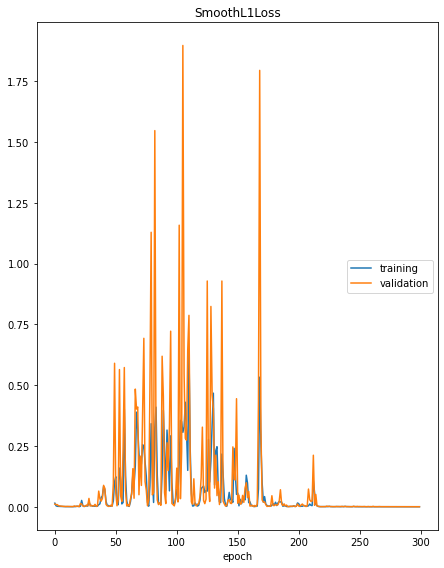

Epoch[300/300]: 100%|██████████| 300/300 [00:50<00:00,  5.95it/s, SmoothL1Loss=0.000143, MAE=3.15, MSE=16.1, RegLoss=0, MAE_val=4.14, MSE_val=28, SmoothL1Loss_val=0.000249]


In [144]:
stats
m.fit(
    df,
    freq=freq,
    validate_each_epoch=True,
    plot_live_loss=True,
    epochs=300
)

In [145]:
output

[     SmoothL1Loss         MAE            MSE  RegLoss  SmoothL1Loss_val  \
 0        0.967677  329.616606  166929.061074      0.0          0.010940   
 1        0.846130  299.843042  135879.707282      0.0          0.008971   
 2        0.738700  273.457511  112155.307499      0.0          0.008728   
 3        0.622746  244.005626   90807.239757      0.0          0.004434   
 4        0.471344  205.302373   62037.968429      0.0          0.003299   
 ..            ...         ...            ...      ...               ...   
 803      0.000144    3.166348      16.224039      0.0               NaN   
 804      0.000145    3.178989      16.290484      0.0               NaN   
 805      0.000144    3.159926      16.162633      0.0               NaN   
 806      0.000144    3.158443      16.133446      0.0               NaN   
 807      0.000143    3.154285      16.108855      0.0               NaN   
 
        MAE_val      MSE_val  
 0    27.281038  1229.310669  
 1    25.793955  1008.05

In [131]:
future = m.make_future_dataframe(
    df=df[['ds', 'y', 'y1', 'y2', 'a0']], 
    regressors_df=df[['y1', 'y2', 'a0']],
    n_historic_predictions=20,
)

In [132]:
forecast = m.predict(df=future)
forecast

ds           y    yhat1 residual1       ar1  \
0  1970-01-09 06:20:00   68.500000     None       NaN      None   
1  1970-01-09 06:32:30   56.705905     None       NaN      None   
2  1970-01-09 06:45:00   58.000000     None       NaN      None   
3  1970-01-09 06:57:30   82.294095     None       NaN      None   
4  1970-01-09 07:10:00   83.500000     None       NaN      None   
5  1970-01-09 07:22:30  105.535534     None       NaN      None   
6  1970-01-09 07:35:00  106.330127     None       NaN      None   
7  1970-01-09 07:47:30  116.829629     None       NaN      None   
8  1970-01-09 08:00:00  117.000000     None       NaN      None   
9  1970-01-09 08:12:30  121.829629     None       NaN      None   
10 1970-01-09 08:25:00  121.330127     None       NaN      None   
11 1970-01-09 08:37:30  117.535534     None       NaN      None   
12 1970-01-09 08:50:00  116.500000     None       NaN      None   
13 1970-01-09 09:02:30  113.294095     None       NaN      None   
14 1970-01-09 09:15:00  112.000000     None       NaN      None   
15 1970-01-09 09:27:30   87.705905     None       NaN      None   
16 1970-01-09 09:40:00   86.500000     None       NaN      None   
17 1970-01-09 09:52:30   72.464466     None       NaN      None   
18 1970-01-09 10:05:00   71.669873     None       NaN      None   
19 1970-01-09 10:17:30   47.170371     None       NaN      None   
20 1970-01-09 10:30:00   47.000000     None       NaN      None   
21 1970-01-09 10:42:30   34.170371     None       NaN      None   
22 1970-01-09 10:55:00   34.669873     None       NaN      None   
23 1970-01-09 11:07:30   29.464466     None       NaN      None   
24 1970-01-09 11:20:00   30.500000     None       NaN      None   
25 1970-01-09 11:32:30   30.705905  37.5177   6.81179  -20.4756   
26 1970-01-09 11:45:00   32.000000   35.756   3.75603  -25.4005   
27 1970-01-09 11:57:30   31.294095  30.8132  -0.48091  -26.0429   
28 1970-01-09 12:10:00   32.500000  38.9086   6.40862  -26.9431   
29 1970-01-09 12:22:30   26.535534  25.1961  -1.33946  -26.5133   
30 1970-01-09 12:35:00   27.330127  31.6045    4.2744  -26.0893   
31 1970-01-09 12:47:30   68.829629   67.089  -1.74062  -24.5347   
32 1970-01-09 13:00:00   69.000000  66.8093  -2.19069  -18.3196   
33 1970-01-09 13:12:30   60.829629  59.1157  -1.71391  -15.1654   
34 1970-01-09 13:25:00   60.330127  62.4508   2.12067  -10.7751   
35 1970-01-09 13:37:30   69.535534  68.1543  -1.38126  -8.88103   
36 1970-01-09 13:50:00   68.500000  74.8556   6.35562 -0.789514   
37 1970-01-09 14:02:30   92.294095   93.997   1.70288   1.40211   
38 1970-01-09 14:15:00   91.000000  100.232   9.23164   8.18749   
39 1970-01-09 14:27:30   28.705905  31.8496   3.14366   10.6585   
40 1970-01-09 14:40:00   27.500000  26.3194  -1.18059   7.99844   
41 1970-01-09 14:52:30   24.464466  22.2744  -2.19008    4.5807   
42 1970-01-09 15:05:00   23.669873  30.5727   6.90288   8.44347   
43 1970-01-09 15:17:30   81.170371  84.7758   3.60546   8.35599   
44 1970-01-09 15:30:00   81.000000  86.9927   5.99266   8.99067   
45 1970-01-09 15:42:30         NaN  105.107       NaN    9.7376   

   lagged_regressor_y11 lagged_regressor_y21     trend season_daily  \
0                  None                 None      None         None   
1                  None                 None      None         None   
2                  None                 None      None         None   
3                  None                 None      None         None   
4                  None                 None      None         None   
5                  None                 None      None         None   
6                  None                 None      None         None   
7                  None                 None      None         None   
8                  None                 None      None         None   
9                  None                 None      None         None   
10                 None                 None      None         None   
11                

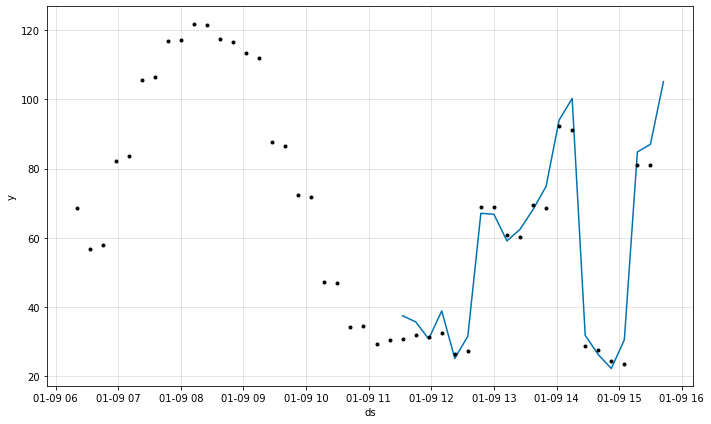

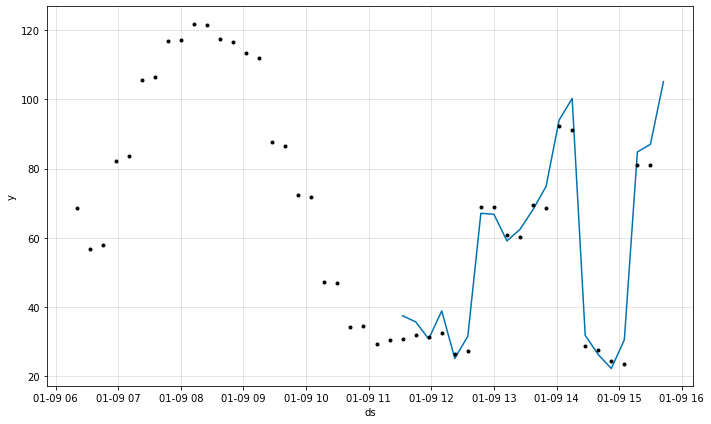

In [133]:
m.plot(forecast, )

  0%|          | 0/200 [00:00<?, ?it/s]

infering freq param as 750S
y: (97, 3)
k: 3
a: (100, 1)
t: (100,)
e: None
freq: 750S


Epoch[400/400]: 100%|██████████| 400/400 [00:07<00:00, 50.91it/s, SmoothL1Loss=0.000201, MAE=2.8, MSE=12.2, RegLoss=0]  


  0%|          | 0/200 [00:00<?, ?it/s]

df (97, 5)
df data              y          y1          y2        a0                  ds
0   264.669873  227.276173  232.034362 -0.965926 1970-01-01 00:00:00
1   226.170371  229.530814  229.543223 -0.866025 1970-01-01 00:12:30
2   226.000000  205.988065  196.604353 -0.707107 1970-01-01 00:25:00
3   193.170371  184.276311  193.407658 -0.500000 1970-01-01 00:37:30
4   193.669873  200.751554  209.703550 -0.258819 1970-01-01 00:50:00
..         ...         ...         ...       ...                 ...
92   91.000000   33.723914   37.237257 -0.707107 1970-01-01 19:10:00
93   28.705905   28.245135   31.454083 -0.866025 1970-01-01 19:22:30
94   27.500000   25.072312   37.099523 -0.965926 1970-01-01 19:35:00
95   24.464466   30.110091   24.188455 -1.000000 1970-01-01 19:47:30
96   23.669873   88.472800  101.272905 -0.965926 1970-01-01 20:00:00

[97 rows x 5 columns]
a_cols ['a0']
a_shorter (100, 1)
future (4, 7)
future data                    ds          y        y1        y2        a0         

Epoch[400/400]: 100%|██████████| 400/400 [00:08<00:00, 48.78it/s, SmoothL1Loss=0.00024, MAE=3.19, MSE=14.6, RegLoss=0] 


forecast                    ds          y    yhat1 residual1       ar1  \
0 1970-01-01 19:35:00  27.500000     None       NaN      None   
1 1970-01-01 19:47:30  24.464466     None       NaN      None   
2 1970-01-01 20:00:00  23.669873     None       NaN      None   
3 1970-01-01 20:12:30        NaN  82.9629       NaN -0.364607   

  lagged_regressor_y11 lagged_regressor_y21 lagged_regressor_a01    trend  
0                 None                 None                 None     None  
1                 None                 None                 None     None  
2                 None                 None                 None     None  
3              53.5126              22.1563             0.427308  7.23131  
forecast1                    ds          y    yhat1 residual1       ar1  \
0 1970-01-01 19:35:00  27.500000     None       NaN      None   
1 1970-01-01 19:47:30  24.464466     None       NaN      None   
2 1970-01-01 20:00:00  23.669873     None       NaN      None   
3 1970-01-01 20

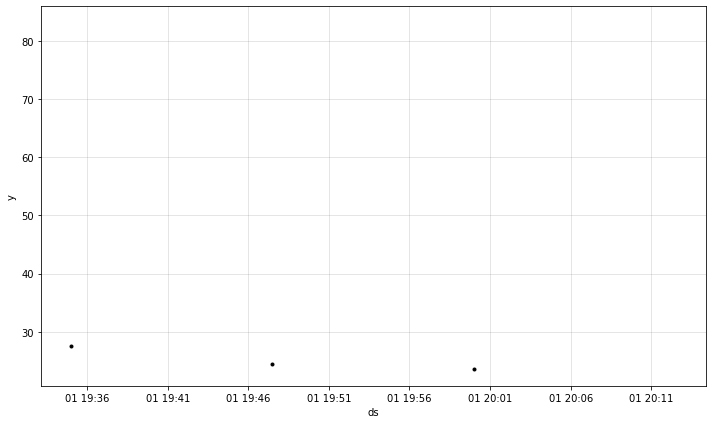

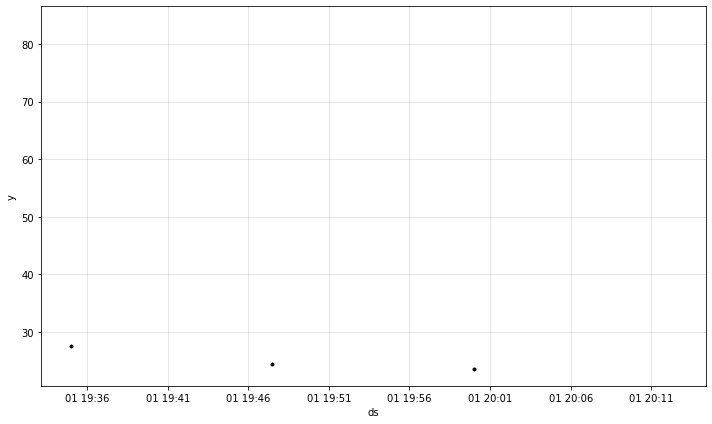

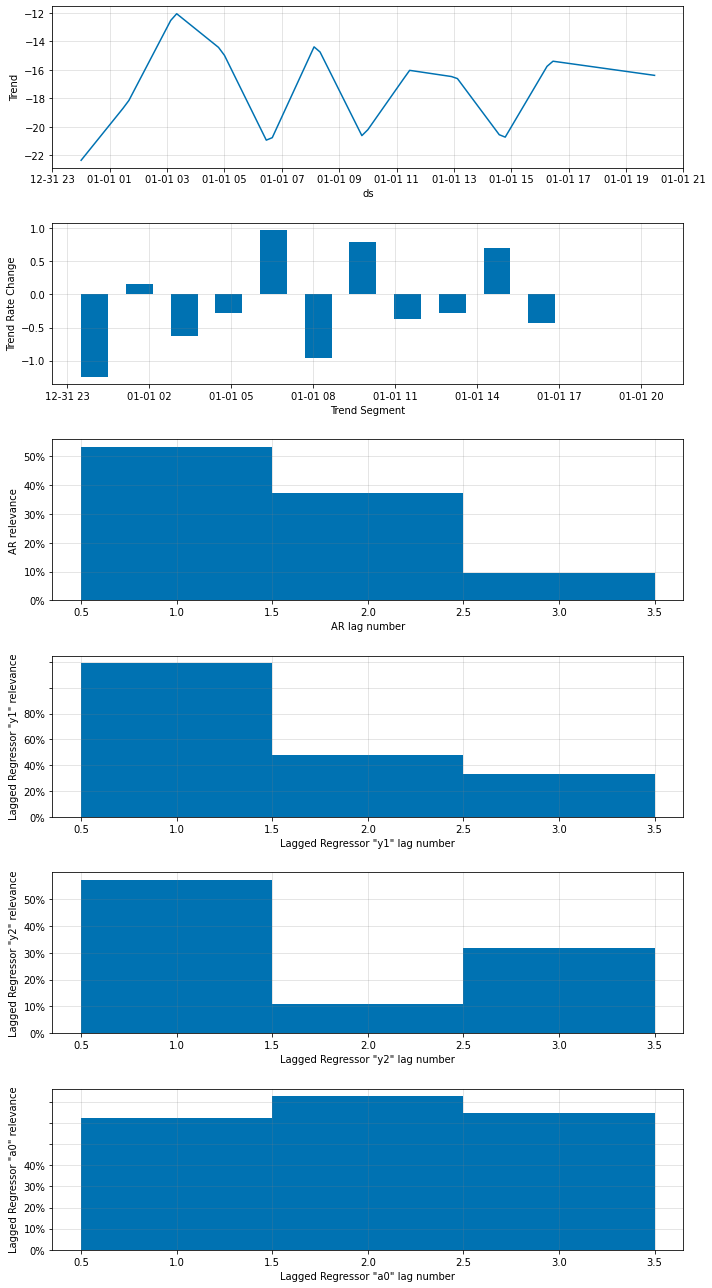

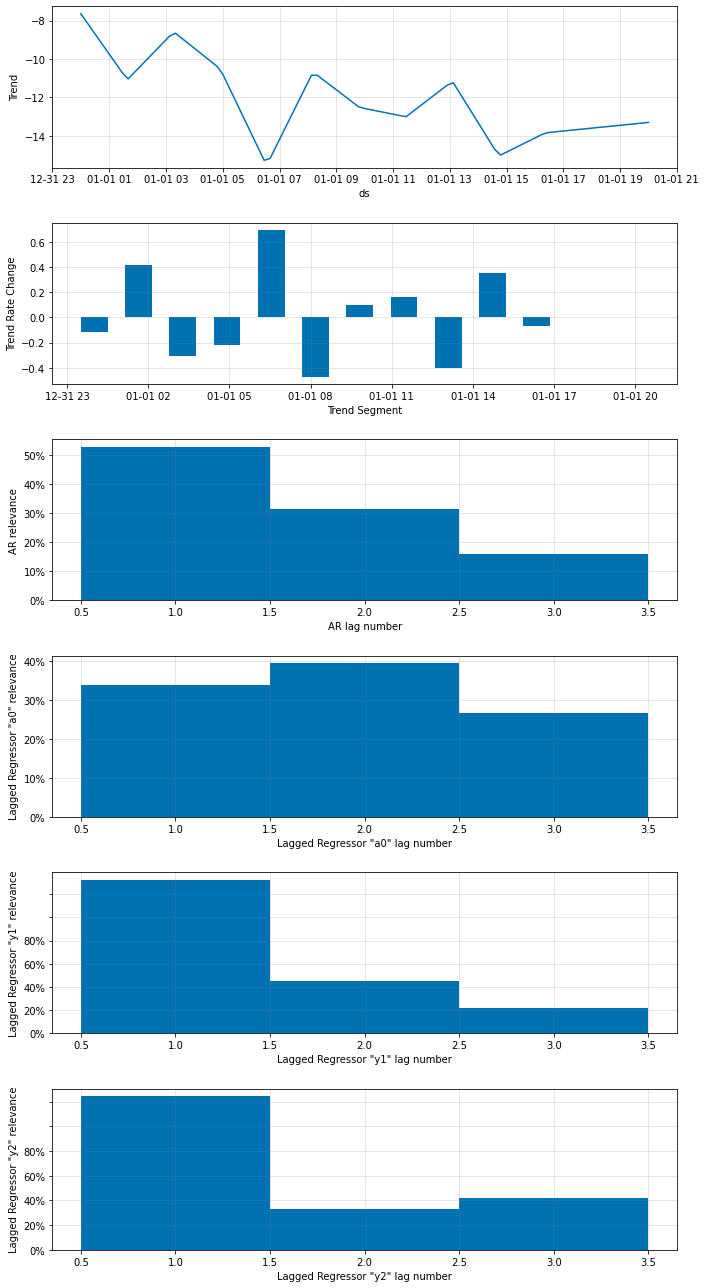

In [14]:
k = 3
n = 100
y, a = hospital_with_exog(k=k, n=n)
y = y[:-k]
t = [i * 15 * 50 for i in range(len(y) + k)]
x, x_std, forecast, m = nprophet_iskater_factory(y=y, k=k, t=t, a=a,)
assert len(x) == k
x1, x_std1, forecast1, m1 = \
    nprophet_fit_and_predict_with_exog_and_advance_vars(y=y, k=k, t=t, a=a)
# assert nearlysame(x1, x, 0.0001)

print('forecast', forecast)
print('forecast1', forecast1)
m.plot(forecast)
m1.plot(forecast1)
m.plot_parameters()
m1.plot_parameters()
import matplotlib.pyplot as plt
plt.show()